# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [3]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

import time

import h2o


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [4]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:


azdias.describe(percentiles = [.25, .5, .75]).transpose()

,count,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0


In [5]:
azdias.shape

(891221, 85)

In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
azdias.isnull()[azdias.isnull() == True].head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#azdias.fillna(0)

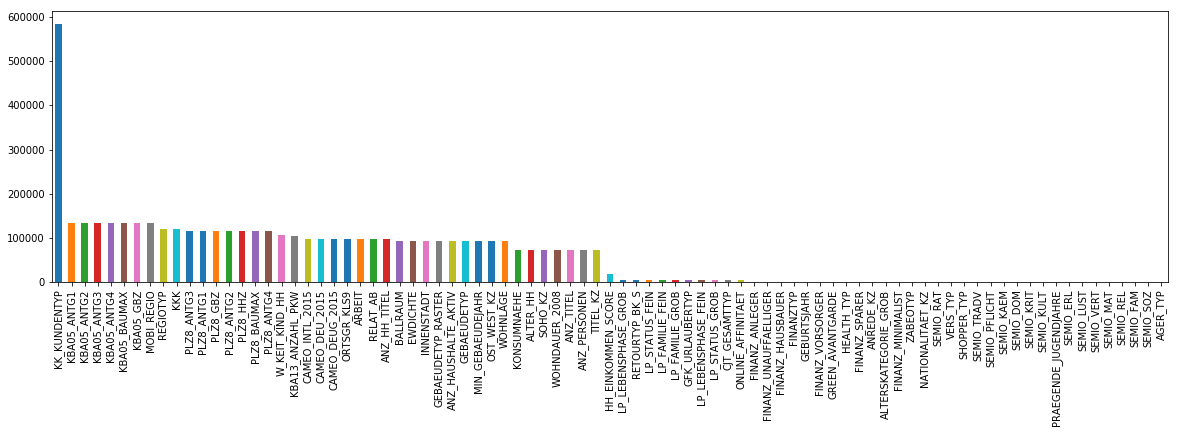

In [8]:
# KK Kundentyp seems to contains 5 times more null values than rest of the features. It may be an outliner
azdias.isnull().sum().sort_values(ascending = False).plot.bar(figsize=(20,5));

In [9]:
#missing values ratio - Yes KK Kundentyp has nulls in excess

(azdias.isnull().sum()/azdias.shape[0]).sort_values(ascending = False)

KK_KUNDENTYP             0.655967
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
KBA05_ANTG4              0.149597
KBA05_BAUMAX             0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
REGIOTYP                 0.135989
KKK                      0.135989
PLZ8_ANTG3               0.130736
PLZ8_ANTG1               0.130736
PLZ8_GBZ                 0.130736
PLZ8_ANTG2               0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
W_KEIT_KIND_HH           0.120735
KBA13_ANZAHL_PKW         0.118714
CAMEO_INTL_2015          0.111060
CAMEO_DEU_2015           0.111060
CAMEO_DEUG_2015          0.111060
ORTSGR_KLS9              0.109082
ARBEIT                   0.109082
RELAT_AB                 0.109082
ANZ_HH_TITEL             0.108848
BALLRAUM                 0.105182
EWDICHTE                 0.105182
INNENSTADT               0.105182
GEBAEUDETYP_RA

In [10]:
#converting missing or unknown values to np nans

miss_values = feat_info['missing_or_unknown']

columns = azdias.columns

azd1 =azdias

print(columns)

print(miss_values[0].split(','))

print(type(miss_values[1][0]))
azdias[columns[1]].unique()


#print(miss_value[1:-1].strip().split(','))
bag = []
for column in columns:
        for miss_value in miss_values:
            for value in miss_value[1:-1].strip().split(','):
                if value != "":
                    bag.append(value)
'''
for column in azdias_columns:
        for miss_value in miss_values:
            for value in miss_value[1:-1].strip().split(','):
                if value != "":
                    if int(value) in azd[azdias_columns]:
                        azd[azdias_columns].replace(int(value), np.nan) '''

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

'\nfor column in azdias_columns:\n        for miss_value in miss_values:\n            for value in miss_value[1:-1].strip().split(\',\'):\n                if value != "":\n                    if int(value) in azd[azdias_columns]:\n                        azd[azdias_columns].replace(int(value), np.nan) '

In [11]:
# missing & known values to remove from the features
miss_bag = []
#pd.DataFrame[data = bag]
for val in set(bag):
    print(val)
    


9
-1
XX
X
0


In [12]:
azd1.shape
#testing : its seems X, XX and -1 are not present in the rows of these columns

for col in columns:
    if 0 in azd1[col]:
        print(col)

#type(int("1")) 

AGER_TYP
ALTERSKATEGORIE_GROB
ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GEBURTSJAHR
GFK_URLAUBERTYP
GREEN_AVANTGARDE
HEALTH_TYP
LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
PRAEGENDE_JUGENDJAHRE
RETOURTYP_BK_S
SEMIO_SOZ
SEMIO_FAM
SEMIO_REL
SEMIO_MAT
SEMIO_VERT
SEMIO_LUST
SEMIO_ERL
SEMIO_KULT
SEMIO_RAT
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
SEMIO_PFLICHT
SEMIO_TRADV
SHOPPER_TYP
SOHO_KZ
TITEL_KZ
VERS_TYP
ZABEOTYP
ALTER_HH
ANZ_PERSONEN
ANZ_TITEL
HH_EINKOMMEN_SCORE
KK_KUNDENTYP
W_KEIT_KIND_HH
WOHNDAUER_2008
ANZ_HAUSHALTE_AKTIV
ANZ_HH_TITEL
GEBAEUDETYP
KONSUMNAEHE
MIN_GEBAEUDEJAHR
OST_WEST_KZ
WOHNLAGE
CAMEO_DEUG_2015
CAMEO_DEU_2015
CAMEO_INTL_2015
KBA05_ANTG1
KBA05_ANTG2
KBA05_ANTG3
KBA05_ANTG4
KBA05_BAUMAX
KBA05_GBZ
BALLRAUM
EWDICHTE
INNENSTADT
GEBAEUDETYP_RASTER
KKK
MOBI_REGIO
ONLINE_AFFINITAET
REGIOTYP
KBA13_ANZAHL_PKW
PLZ8_ANTG

In [13]:
# all the unique values in each of the feature in the data set azdias

azd1[col].unique()
uni_bag = []
# looking for missing & unknown values found XX
for col in columns:
    print(col)
    print(azd1[col].unique())

AGER_TYP
[-1  2  3  0  1]
ALTERSKATEGORIE_GROB
[2 1 3 4 9]
ANREDE_KZ
[1 2]
CJT_GESAMTTYP
[ 2.  5.  3.  4.  1.  6. nan]
FINANZ_MINIMALIST
[3 1 4 2 5]
FINANZ_SPARER
[4 5 2 3 1]
FINANZ_VORSORGER
[3 2 1 5 4]
FINANZ_ANLEGER
[5 2 1 4 3]
FINANZ_UNAUFFAELLIGER
[5 4 3 1 2]
FINANZ_HAUSBAUER
[3 5 2 4 1]
FINANZTYP
[4 1 6 5 2 3]
GEBURTSJAHR
[   0 1996 1979 1957 1963 1943 1964 1974 1975 1941 1993 1946 1988 1991
 1966 1949 1982 1972 1990 1985 1989 1948 1935 1997 1994 1987 2002 1950
 1965 1969 1978 1958 1944 1967 1977 1960 1970 1973 1971 1937 1947 1926
 1954 1981 1962 1992 2008 1976 1928 1927 1968 1940 1952 1961 2006 1938
 1945 1942 1984 1930 1980 1959 1986 1931 1955 1983 2010 1951 1921 1929
 1939 2001 1995 1956 1953 2012 1934 1913 1914 1922 2004 1936 2009 1915
 2003 2013 1998 2007 1932 2005 1923 1925 2015 1933 2017 2000 1999 2014
 1920 1918 1924 2016 2011 1908 1919 1916 1917 1912 1911 1909 1910 1904
 1906 1905 1900 1907 1902]
GFK_URLAUBERTYP
[10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
GREEN

In [14]:
# all the unique values and thier counts in each of the feature in the data set azdias
miss_bag = ['X', '0', '-1', 'XX', '9', 0,-1,9]
azd1[col].unique()
#print(azd.unique())
index_name = azd1[col].value_counts().sort_values(ascending = False).index.tolist()
uni_bag = []
# looking for missing & unknown values found XX

for col in columns:
    print(col)
    print(azd1[col].unique())
    print("Total rows: ", azd1[col].sum())
    print(azd1[col].value_counts().sort_values(ascending = False), 
          pd.DataFrame(data = azd1[col].value_counts().sort_values(ascending = False).values/azd1[col].shape[0], 
                   index = azd1[col].value_counts().sort_values(ascending = False).index.tolist(),
                      columns = ["Ratio To Total Rows"]))
    print('---------------------------------------------------------------------/n/n')

AGER_TYP
[-1  2  3  0  1]
Total rows:  -319445
-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64     Ratio To Total Rows
-1             0.760196
 2             0.110491
 1             0.089542
 3             0.030412
 0             0.009358
---------------------------------------------------------------------/n/n
ALTERSKATEGORIE_GROB
[2 1 3 4 9]
Total rows:  2475275
3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64    Ratio To Total Rows
3             0.402294
4             0.256401
2             0.177745
1             0.160327
9             0.003233
---------------------------------------------------------------------/n/n
ANREDE_KZ
[1 2]
Total rows:  1356526
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64    Ratio To Total Rows
2             0.522098
1             0.477902
---------------------------------------------------------------------/n/n
CJT_GESAMTTYP
[ 2.  5.  3.  4.  1.  6. n

 3    310693
 2    306944
 1    162388
-1    111196
Name: HEALTH_TYP, dtype: int64     Ratio To Total Rows
 3             0.348615
 2             0.344408
 1             0.182208
-1             0.124768
---------------------------------------------------------------------/n/n
LP_LEBENSPHASE_FEIN
[15. 21.  3.  0. 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
  9. 34. nan 40. 16. 17.]
Total rows:  12961023.0
0.0     92778
1.0     62667
5.0     55542
6.0     45614
2.0     39434
8.0     30475
11.0    26710
29.0    26577
7.0     26508
13.0    26085
10.0    25789
31.0    23987
12.0    23300
30.0    22361
15.0    20062
3.0     19985
19.0    19484
37.0    18525
4.0     17595
14.0    17529
20.0    17132
32.0    17105
39.0    16182
40.0    15150
27.0    14475
16.0    14466
38.0    13914
35.0    13679
34.0    13074
9.0     13066
21.0    12766
28.0    12264
24.0    12091
36.0    10505
25.0    10370
23.0     9191
22.

[1 4 7 2 6 5 3]
Total rows:  3586014
2    204333
6    141714
5    135205
7    134756
4    122982
1    120437
3     31794
Name: SEMIO_VERT, dtype: int64    Ratio To Total Rows
2             0.229273
6             0.159011
5             0.151708
7             0.151204
4             0.137993
1             0.135137
3             0.035675
---------------------------------------------------------------------/n/n
SEMIO_LUST
[5 2 4 6 7 3 1]
Total rows:  3884909
5    170040
6    158624
7    158234
2    114373
1    110382
4     97495
3     82073
Name: SEMIO_LUST, dtype: int64    Ratio To Total Rows
5             0.190794
6             0.177985
7             0.177547
2             0.128333
1             0.123855
4             0.109395
3             0.092091
---------------------------------------------------------------------/n/n
SEMIO_ERL
[3 2 6 7 4 5 1]
Total rows:  3993922
4    196206
3    180824
7    179141
6    139209
2     77012
5     76133
1     42696
Name: SEMIO_ERL, dtype: int64    Ratio

0.0    814542
1.0      2970
2.0       202
3.0         5
4.0         2
6.0         1
Name: ANZ_TITEL, dtype: int64      Ratio To Total Rows
0.0             0.913962
1.0             0.003333
2.0             0.000227
3.0             0.000006
4.0             0.000002
6.0             0.000001
---------------------------------------------------------------------/n/n
HH_EINKOMMEN_SCORE
[ 2.  6.  4.  1.  5.  3. nan]
Total rows:  3672389.0
6.0    252775
5.0    201482
2.0    140817
4.0    139762
3.0     84805
1.0     53232
Name: HH_EINKOMMEN_SCORE, dtype: int64      Ratio To Total Rows
6.0             0.283628
5.0             0.226074
2.0             0.158005
4.0             0.156821
3.0             0.095156
1.0             0.059729
---------------------------------------------------------------------/n/n
KK_KUNDENTYP
[nan  1.  3.  6.  4.  2.  5.]
Total rows:  1045733.0
3.0    65151
2.0    62564
5.0    48038
4.0    44512
6.0    44114
1.0    42230
Name: KK_KUNDENTYP, dtype: int64      Ratio To To

1.0    193738
3.0    171127
5.0    153535
2.0    134665
4.0    133324
6.0     26625
7.0      4238
Name: KONSUMNAEHE, dtype: int64      Ratio To Total Rows
1.0             0.217385
3.0             0.192014
5.0             0.172275
2.0             0.151102
4.0             0.149597
6.0             0.029875
7.0             0.004755
---------------------------------------------------------------------/n/n
MIN_GEBAEUDEJAHR
[  nan 1992. 1997. 2005. 2009. 1994. 1996. 2002. 2015. 1991. 1993. 1995.
 2003. 2014. 2008. 2006. 2000. 1990. 2004. 1999. 1998. 2001. 2007. 2013.
 1989. 2011. 2012. 2010. 1987. 1988. 1985. 2016. 1986.]
Total rows:  1590780564.0
1992.0    568776
1994.0     78835
1993.0     25488
1995.0     25464
1996.0     16611
1997.0     14464
2000.0      7382
2001.0      5877
1991.0      5811
2005.0      5553
1999.0      4413
1990.0      4408
2002.0      4216
1998.0      4097
2003.0      3356
2004.0      2935
2008.0      2197
2007.0      2156
1989.0      2046
2009.0      2016
2006.0     

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [16]:
# removing the missing & unknown values

def fill_na_to_df(dataframe, miss_values):
    bag = []
    for column in dataframe.columns:
        for miss_value in miss_values:
            for value in miss_value[1:-1].strip().split(','):
                if value != "":
                    
                    bag.append(value)
    for val in set(bag):
        for column in dataframe.columns:
            try:
                dataframe[column] = dataframe[column].replace(int(val), np.nan)
                print("Removing int val: " + val + " from the feature " + column)
                dataframe[column] = dataframe[column].replace(val, np.nan)
                print("Removing string val: " + val + " from the feature " + column)
            except:
                dataframe[column] = dataframe[column].replace(val, np.nan)
                print("Removing alphabets: " + val + " from the feature " + column)

    return dataframe

In [17]:
# test case for removing missing & unknown values

df_test = fill_na_to_df(azd1,miss_values)

Removing int val: 9 from the feature AGER_TYP
Removing string val: 9 from the feature AGER_TYP
Removing int val: 9 from the feature ALTERSKATEGORIE_GROB
Removing string val: 9 from the feature ALTERSKATEGORIE_GROB
Removing int val: 9 from the feature ANREDE_KZ
Removing string val: 9 from the feature ANREDE_KZ
Removing int val: 9 from the feature CJT_GESAMTTYP
Removing string val: 9 from the feature CJT_GESAMTTYP
Removing int val: 9 from the feature FINANZ_MINIMALIST
Removing string val: 9 from the feature FINANZ_MINIMALIST
Removing int val: 9 from the feature FINANZ_SPARER
Removing string val: 9 from the feature FINANZ_SPARER
Removing int val: 9 from the feature FINANZ_VORSORGER
Removing string val: 9 from the feature FINANZ_VORSORGER
Removing int val: 9 from the feature FINANZ_ANLEGER
Removing string val: 9 from the feature FINANZ_ANLEGER
Removing int val: 9 from the feature FINANZ_UNAUFFAELLIGER
Removing string val: 9 from the feature FINANZ_UNAUFFAELLIGER
Removing int val: 9 from th

Removing string val: 9 from the feature PLZ8_BAUMAX
Removing int val: 9 from the feature PLZ8_HHZ
Removing string val: 9 from the feature PLZ8_HHZ
Removing int val: 9 from the feature PLZ8_GBZ
Removing string val: 9 from the feature PLZ8_GBZ
Removing int val: 9 from the feature ARBEIT
Removing string val: 9 from the feature ARBEIT
Removing int val: 9 from the feature ORTSGR_KLS9
Removing string val: 9 from the feature ORTSGR_KLS9
Removing int val: 9 from the feature RELAT_AB
Removing string val: 9 from the feature RELAT_AB
Removing int val: -1 from the feature AGER_TYP
Removing string val: -1 from the feature AGER_TYP
Removing int val: -1 from the feature ALTERSKATEGORIE_GROB
Removing string val: -1 from the feature ALTERSKATEGORIE_GROB
Removing int val: -1 from the feature ANREDE_KZ
Removing string val: -1 from the feature ANREDE_KZ
Removing int val: -1 from the feature CJT_GESAMTTYP
Removing string val: -1 from the feature CJT_GESAMTTYP
Removing int val: -1 from the feature FINANZ_MI

Removing string val: -1 from the feature REGIOTYP
Removing int val: -1 from the feature KBA13_ANZAHL_PKW
Removing string val: -1 from the feature KBA13_ANZAHL_PKW
Removing int val: -1 from the feature PLZ8_ANTG1
Removing string val: -1 from the feature PLZ8_ANTG1
Removing int val: -1 from the feature PLZ8_ANTG2
Removing string val: -1 from the feature PLZ8_ANTG2
Removing int val: -1 from the feature PLZ8_ANTG3
Removing string val: -1 from the feature PLZ8_ANTG3
Removing int val: -1 from the feature PLZ8_ANTG4
Removing string val: -1 from the feature PLZ8_ANTG4
Removing int val: -1 from the feature PLZ8_BAUMAX
Removing string val: -1 from the feature PLZ8_BAUMAX
Removing int val: -1 from the feature PLZ8_HHZ
Removing string val: -1 from the feature PLZ8_HHZ
Removing int val: -1 from the feature PLZ8_GBZ
Removing string val: -1 from the feature PLZ8_GBZ
Removing int val: -1 from the feature ARBEIT
Removing string val: -1 from the feature ARBEIT
Removing int val: -1 from the feature ORTSG

Removing alphabets: X from the feature ANZ_HAUSHALTE_AKTIV
Removing alphabets: X from the feature ANZ_HH_TITEL
Removing alphabets: X from the feature GEBAEUDETYP
Removing alphabets: X from the feature KONSUMNAEHE
Removing alphabets: X from the feature MIN_GEBAEUDEJAHR
Removing alphabets: X from the feature OST_WEST_KZ
Removing alphabets: X from the feature WOHNLAGE
Removing alphabets: X from the feature CAMEO_DEUG_2015
Removing alphabets: X from the feature CAMEO_DEU_2015
Removing alphabets: X from the feature CAMEO_INTL_2015
Removing alphabets: X from the feature KBA05_ANTG1
Removing alphabets: X from the feature KBA05_ANTG2
Removing alphabets: X from the feature KBA05_ANTG3
Removing alphabets: X from the feature KBA05_ANTG4
Removing alphabets: X from the feature KBA05_BAUMAX
Removing alphabets: X from the feature KBA05_GBZ
Removing alphabets: X from the feature BALLRAUM
Removing alphabets: X from the feature EWDICHTE
Removing alphabets: X from the feature INNENSTADT
Removing alphabet

Removing string val: 0 from the feature KBA05_ANTG3
Removing int val: 0 from the feature KBA05_ANTG4
Removing string val: 0 from the feature KBA05_ANTG4
Removing int val: 0 from the feature KBA05_BAUMAX
Removing string val: 0 from the feature KBA05_BAUMAX
Removing int val: 0 from the feature KBA05_GBZ
Removing string val: 0 from the feature KBA05_GBZ
Removing int val: 0 from the feature BALLRAUM
Removing string val: 0 from the feature BALLRAUM
Removing int val: 0 from the feature EWDICHTE
Removing string val: 0 from the feature EWDICHTE
Removing int val: 0 from the feature INNENSTADT
Removing string val: 0 from the feature INNENSTADT
Removing int val: 0 from the feature GEBAEUDETYP_RASTER
Removing string val: 0 from the feature GEBAEUDETYP_RASTER
Removing int val: 0 from the feature KKK
Removing string val: 0 from the feature KKK
Removing int val: 0 from the feature MOBI_REGIO
Removing string val: 0 from the feature MOBI_REGIO
Removing int val: 0 from the feature ONLINE_AFFINITAET
Remo

In [18]:
# testing to find missing & unknown values
# Test Sucessful! all unknown and missing values imputed

for col in columns:
    print(col)
    print(azd1[col].unique())
    print("Total rows: ", azd1[col].sum())
    print(azd1[col].value_counts().sort_values(ascending = False), 
          pd.DataFrame(data = azd1[col].value_counts().sort_values(ascending = False).values/azd1[col].shape[0], 
                   index = azd1[col].value_counts().sort_values(ascending = False).index.tolist(),
                      columns = ["Ratio To Total Rows"]))
    print('---------------------------------------------------------------------/n/n')

AGER_TYP
[nan  2.  3.  1.]
Total rows:  358058.0
2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64      Ratio To Total Rows
2.0             0.110491
1.0             0.089542
3.0             0.030412
---------------------------------------------------------------------/n/n
ALTERSKATEGORIE_GROB
[ 2.  1.  3.  4. nan]
Total rows:  2449346.0
3.0    358533
4.0    228510
2.0    158410
1.0    142887
Name: ALTERSKATEGORIE_GROB, dtype: int64      Ratio To Total Rows
3.0             0.402294
4.0             0.256401
2.0             0.177745
1.0             0.160327
---------------------------------------------------------------------/n/n
ANREDE_KZ
[1 2]
Total rows:  1356526
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64    Ratio To Total Rows
2             0.522098
1             0.477902
---------------------------------------------------------------------/n/n
CJT_GESAMTTYP
[ 2.  5.  3.  4.  1.  6. nan]
Total rows:  3220028.0
4.0    210963
3.0    156449
6.0    153915
2.0 

3.0    310693
2.0    306944
1.0    162388
Name: HEALTH_TYP, dtype: int64      Ratio To Total Rows
3.0             0.348615
2.0             0.344408
1.0             0.182208
---------------------------------------------------------------------/n/n
LP_LEBENSPHASE_FEIN
[15. 21.  3. nan 32.  8.  2.  5. 10.  4.  6. 23. 12. 20.  1. 11. 25. 13.
  7. 18. 31. 19. 38. 35. 30. 22. 14. 33. 29. 24. 28. 37. 26. 39. 27. 36.
 34. 40. 16. 17.]
Total rows:  12843429.0
1.0     62667
5.0     55542
6.0     45614
2.0     39434
8.0     30475
11.0    26710
29.0    26577
7.0     26508
13.0    26085
10.0    25789
31.0    23987
12.0    23300
30.0    22361
15.0    20062
3.0     19985
19.0    19484
37.0    18525
4.0     17595
14.0    17529
20.0    17132
32.0    17105
39.0    16182
40.0    15150
27.0    14475
16.0    14466
38.0    13914
35.0    13679
34.0    13074
21.0    12766
28.0    12264
24.0    12091
36.0    10505
25.0    10370
23.0     9191
22.0     7224
18.0     7168
33.0     6066
17.0     5888
26.0     3584

[nan  3.  2.  6.  5.  4.  1.]
Total rows:  3082292.0
6.0    281966
4.0    128675
3.0    100170
2.0     84000
1.0     83706
5.0     64716
Name: W_KEIT_KIND_HH, dtype: int64      Ratio To Total Rows
6.0             0.316382
4.0             0.144381
3.0             0.112396
2.0             0.094253
1.0             0.093923
5.0             0.072615
---------------------------------------------------------------------/n/n
WOHNDAUER_2008
[nan  8.  3.  4.  5.  6.  2.  7.  1.]
Total rows:  1506608.0
8.0    80118
4.0    50736
3.0    38767
6.0    35170
5.0    30959
7.0    23939
2.0     6174
1.0      683
Name: WOHNDAUER_2008, dtype: int64      Ratio To Total Rows
8.0             0.089897
4.0             0.056929
3.0             0.043499
6.0             0.039463
5.0             0.034738
7.0             0.026861
2.0             0.006928
1.0             0.000766
---------------------------------------------------------------------/n/n
ANZ_HAUSHALTE_AKTIV
[ nan  11.  10.   1.   3.   5.   4.   6.   2.

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [19]:
#implementing in the actual data set

azdias = fill_na_to_df(azdias,miss_values)

Removing int val: 9 from the feature AGER_TYP
Removing string val: 9 from the feature AGER_TYP
Removing int val: 9 from the feature ALTERSKATEGORIE_GROB
Removing string val: 9 from the feature ALTERSKATEGORIE_GROB
Removing int val: 9 from the feature ANREDE_KZ
Removing string val: 9 from the feature ANREDE_KZ
Removing int val: 9 from the feature CJT_GESAMTTYP
Removing string val: 9 from the feature CJT_GESAMTTYP
Removing int val: 9 from the feature FINANZ_MINIMALIST
Removing string val: 9 from the feature FINANZ_MINIMALIST
Removing int val: 9 from the feature FINANZ_SPARER
Removing string val: 9 from the feature FINANZ_SPARER
Removing int val: 9 from the feature FINANZ_VORSORGER
Removing string val: 9 from the feature FINANZ_VORSORGER
Removing int val: 9 from the feature FINANZ_ANLEGER
Removing string val: 9 from the feature FINANZ_ANLEGER
Removing int val: 9 from the feature FINANZ_UNAUFFAELLIGER
Removing string val: 9 from the feature FINANZ_UNAUFFAELLIGER
Removing int val: 9 from th

Removing string val: 9 from the feature PLZ8_BAUMAX
Removing int val: 9 from the feature PLZ8_HHZ
Removing string val: 9 from the feature PLZ8_HHZ
Removing int val: 9 from the feature PLZ8_GBZ
Removing string val: 9 from the feature PLZ8_GBZ
Removing int val: 9 from the feature ARBEIT
Removing string val: 9 from the feature ARBEIT
Removing int val: 9 from the feature ORTSGR_KLS9
Removing string val: 9 from the feature ORTSGR_KLS9
Removing int val: 9 from the feature RELAT_AB
Removing string val: 9 from the feature RELAT_AB
Removing int val: -1 from the feature AGER_TYP
Removing string val: -1 from the feature AGER_TYP
Removing int val: -1 from the feature ALTERSKATEGORIE_GROB
Removing string val: -1 from the feature ALTERSKATEGORIE_GROB
Removing int val: -1 from the feature ANREDE_KZ
Removing string val: -1 from the feature ANREDE_KZ
Removing int val: -1 from the feature CJT_GESAMTTYP
Removing string val: -1 from the feature CJT_GESAMTTYP
Removing int val: -1 from the feature FINANZ_MI

Removing string val: -1 from the feature REGIOTYP
Removing int val: -1 from the feature KBA13_ANZAHL_PKW
Removing string val: -1 from the feature KBA13_ANZAHL_PKW
Removing int val: -1 from the feature PLZ8_ANTG1
Removing string val: -1 from the feature PLZ8_ANTG1
Removing int val: -1 from the feature PLZ8_ANTG2
Removing string val: -1 from the feature PLZ8_ANTG2
Removing int val: -1 from the feature PLZ8_ANTG3
Removing string val: -1 from the feature PLZ8_ANTG3
Removing int val: -1 from the feature PLZ8_ANTG4
Removing string val: -1 from the feature PLZ8_ANTG4
Removing int val: -1 from the feature PLZ8_BAUMAX
Removing string val: -1 from the feature PLZ8_BAUMAX
Removing int val: -1 from the feature PLZ8_HHZ
Removing string val: -1 from the feature PLZ8_HHZ
Removing int val: -1 from the feature PLZ8_GBZ
Removing string val: -1 from the feature PLZ8_GBZ
Removing int val: -1 from the feature ARBEIT
Removing string val: -1 from the feature ARBEIT
Removing int val: -1 from the feature ORTSG

Removing alphabets: X from the feature ANZ_HAUSHALTE_AKTIV
Removing alphabets: X from the feature ANZ_HH_TITEL
Removing alphabets: X from the feature GEBAEUDETYP
Removing alphabets: X from the feature KONSUMNAEHE
Removing alphabets: X from the feature MIN_GEBAEUDEJAHR
Removing alphabets: X from the feature OST_WEST_KZ
Removing alphabets: X from the feature WOHNLAGE
Removing alphabets: X from the feature CAMEO_DEUG_2015
Removing alphabets: X from the feature CAMEO_DEU_2015
Removing alphabets: X from the feature CAMEO_INTL_2015
Removing alphabets: X from the feature KBA05_ANTG1
Removing alphabets: X from the feature KBA05_ANTG2
Removing alphabets: X from the feature KBA05_ANTG3
Removing alphabets: X from the feature KBA05_ANTG4
Removing alphabets: X from the feature KBA05_BAUMAX
Removing alphabets: X from the feature KBA05_GBZ
Removing alphabets: X from the feature BALLRAUM
Removing alphabets: X from the feature EWDICHTE
Removing alphabets: X from the feature INNENSTADT
Removing alphabet

Removing string val: 0 from the feature KBA05_ANTG4
Removing int val: 0 from the feature KBA05_BAUMAX
Removing string val: 0 from the feature KBA05_BAUMAX
Removing int val: 0 from the feature KBA05_GBZ
Removing string val: 0 from the feature KBA05_GBZ
Removing int val: 0 from the feature BALLRAUM
Removing string val: 0 from the feature BALLRAUM
Removing int val: 0 from the feature EWDICHTE
Removing string val: 0 from the feature EWDICHTE
Removing int val: 0 from the feature INNENSTADT
Removing string val: 0 from the feature INNENSTADT
Removing int val: 0 from the feature GEBAEUDETYP_RASTER
Removing string val: 0 from the feature GEBAEUDETYP_RASTER
Removing int val: 0 from the feature KKK
Removing string val: 0 from the feature KKK
Removing int val: 0 from the feature MOBI_REGIO
Removing string val: 0 from the feature MOBI_REGIO
Removing int val: 0 from the feature ONLINE_AFFINITAET
Removing string val: 0 from the feature ONLINE_AFFINITAET
Removing int val: 0 from the feature REGIOTYP
R

In [20]:
for col in columns:
    print(col)
    print(azdias[col].unique())

AGER_TYP
[nan  2.  3.  1.]
ALTERSKATEGORIE_GROB
[ 2.  1.  3.  4. nan]
ANREDE_KZ
[1 2]
CJT_GESAMTTYP
[ 2.  5.  3.  4.  1.  6. nan]
FINANZ_MINIMALIST
[3 1 4 2 5]
FINANZ_SPARER
[4 5 2 3 1]
FINANZ_VORSORGER
[3 2 1 5 4]
FINANZ_ANLEGER
[5 2 1 4 3]
FINANZ_UNAUFFAELLIGER
[5 4 3 1 2]
FINANZ_HAUSBAUER
[3 5 2 4 1]
FINANZTYP
[4 1 6 5 2 3]
GEBURTSJAHR
[  nan 1996. 1979. 1957. 1963. 1943. 1964. 1974. 1975. 1941. 1993. 1946.
 1988. 1991. 1966. 1949. 1982. 1972. 1990. 1985. 1989. 1948. 1935. 1997.
 1994. 1987. 2002. 1950. 1965. 1969. 1978. 1958. 1944. 1967. 1977. 1960.
 1970. 1973. 1971. 1937. 1947. 1926. 1954. 1981. 1962. 1992. 2008. 1976.
 1928. 1927. 1968. 1940. 1952. 1961. 2006. 1938. 1945. 1942. 1984. 1930.
 1980. 1959. 1986. 1931. 1955. 1983. 2010. 1951. 1921. 1929. 1939. 2001.
 1995. 1956. 1953. 2012. 1934. 1913. 1914. 1922. 2004. 1936. 2009. 1915.
 2003. 2013. 1998. 2007. 1932. 2005. 1923. 1925. 2015. 1933. 2017. 2000.
 1999. 2014. 1920. 1918. 1924. 2016. 2011. 1908. 1919. 1916. 1917. 1912.
 1

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [21]:
# Perform an assessment of how much missing data is there in each column of the
# dataset.

azdias.isnull().sum().sort_values(ascending = False)

TITEL_KZ                 889061
ANZ_TITEL                888041
SOHO_KZ                  884333
ANZ_HH_TITEL             867286
KBA05_ANTG4              733495
GREEN_AVANTGARDE         715996
AGER_TYP                 685843
KBA05_ANTG3              644869
WOHNDAUER_2008           624675
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
PLZ8_ANTG4               472904
KBA05_ANTG2              425862
KBA05_ANTG1              394373
GEBURTSJAHR              392318
ALTER_HH                 333084
SHOPPER_TYP              238778
PLZ8_ANTG3               236309
CAMEO_DEUG_2015          207529
ORTSGR_KLS9              189153
KKK                      158064
REGIOTYP                 158064
LP_STATUS_FEIN           148092
W_KEIT_KIND_HH           147988
LP_LEBENSPHASE_GROB      143510
PRAEGENDE_JUGENDJAHRE    141734
MOBI_REGIO               133324
KBA05_GBZ                133324
ANZ_HAUSHALTE_AKTIV      128613
PLZ8_ANTG2               123953
                          ...  
ONLINE_A

In [22]:
# Investigate patterns in the amount of missing data in each column.

(azdias.isnull().sum()/azdias.shape[0]).sort_values(ascending = False)

TITEL_KZ                 0.997576
ANZ_TITEL                0.996432
SOHO_KZ                  0.992271
ANZ_HH_TITEL             0.973144
KBA05_ANTG4              0.823023
GREEN_AVANTGARDE         0.803388
AGER_TYP                 0.769554
KBA05_ANTG3              0.723579
WOHNDAUER_2008           0.700920
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
PLZ8_ANTG4               0.530625
KBA05_ANTG2              0.477841
KBA05_ANTG1              0.442509
GEBURTSJAHR              0.440203
ALTER_HH                 0.373739
SHOPPER_TYP              0.267922
PLZ8_ANTG3               0.265152
CAMEO_DEUG_2015          0.232859
ORTSGR_KLS9              0.212240
KKK                      0.177357
REGIOTYP                 0.177357
LP_STATUS_FEIN           0.166168
W_KEIT_KIND_HH           0.166051
LP_LEBENSPHASE_GROB      0.161026
PRAEGENDE_JUGENDJAHRE    0.159034
MOBI_REGIO               0.149597
KBA05_GBZ                0.149597
ANZ_HAUSHALTE_AKTIV      0.144311
PLZ8_ANTG2    

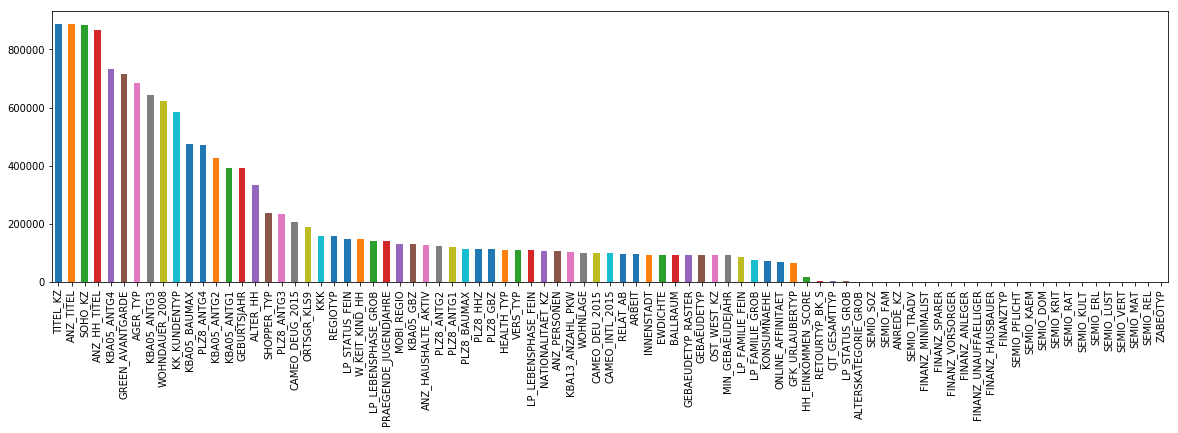

In [23]:
# null values present in the features of the azdias data set after imputing missing and unknown values to null

azdias.isnull().sum().sort_values(ascending = False).plot.bar(figsize=(20,5));

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

print((azdias.isnull().sum()/azdias.shape[0]).sort_values(ascending = False).index)
print((azdias.isnull().sum()/azdias.shape[0]).sort_values(ascending = False) < .35)

Index(['TITEL_KZ', 'ANZ_TITEL', 'SOHO_KZ', 'ANZ_HH_TITEL', 'KBA05_ANTG4',
       'GREEN_AVANTGARDE', 'AGER_TYP', 'KBA05_ANTG3', 'WOHNDAUER_2008',
       'KK_KUNDENTYP', 'KBA05_BAUMAX', 'PLZ8_ANTG4', 'KBA05_ANTG2',
       'KBA05_ANTG1', 'GEBURTSJAHR', 'ALTER_HH', 'SHOPPER_TYP', 'PLZ8_ANTG3',
       'CAMEO_DEUG_2015', 'ORTSGR_KLS9', 'KKK', 'REGIOTYP', 'LP_STATUS_FEIN',
       'W_KEIT_KIND_HH', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
       'MOBI_REGIO', 'KBA05_GBZ', 'ANZ_HAUSHALTE_AKTIV', 'PLZ8_ANTG2',
       'PLZ8_ANTG1', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'HEALTH_TYP',
       'VERS_TYP', 'LP_LEBENSPHASE_FEIN', 'NATIONALITAET_KZ', 'ANZ_PERSONEN',
       'KBA13_ANZAHL_PKW', 'WOHNLAGE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015',
       'RELAT_AB', 'ARBEIT', 'INNENSTADT', 'EWDICHTE', 'BALLRAUM',
       'GEBAEUDETYP_RASTER', 'GEBAEUDETYP', 'OST_WEST_KZ', 'MIN_GEBAEUDEJAHR',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'KONSUMNAEHE',
       'ONLINE_AFFINITAET', 'GFK_URLAUBERTYP', 'HH_E

In [25]:
# removing features which contain more than 35% null values

total_null_columns = (azdias.isnull().sum()/azdias.shape[0]).sort_values(ascending = False).index.tolist()
null_columns = []
for i,value in enumerate((azdias.isnull().sum()/azdias.shape[0]).sort_values(ascending = False) < .35):
    if value == True:
        null_columns.append(total_null_columns[i])
        

print(null_columns)        

['SHOPPER_TYP', 'PLZ8_ANTG3', 'CAMEO_DEUG_2015', 'ORTSGR_KLS9', 'KKK', 'REGIOTYP', 'LP_STATUS_FEIN', 'W_KEIT_KIND_HH', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'MOBI_REGIO', 'KBA05_GBZ', 'ANZ_HAUSHALTE_AKTIV', 'PLZ8_ANTG2', 'PLZ8_ANTG1', 'PLZ8_BAUMAX', 'PLZ8_HHZ', 'PLZ8_GBZ', 'HEALTH_TYP', 'VERS_TYP', 'LP_LEBENSPHASE_FEIN', 'NATIONALITAET_KZ', 'ANZ_PERSONEN', 'KBA13_ANZAHL_PKW', 'WOHNLAGE', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'RELAT_AB', 'ARBEIT', 'INNENSTADT', 'EWDICHTE', 'BALLRAUM', 'GEBAEUDETYP_RASTER', 'GEBAEUDETYP', 'OST_WEST_KZ', 'MIN_GEBAEUDEJAHR', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'KONSUMNAEHE', 'ONLINE_AFFINITAET', 'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'RETOURTYP_BK_S', 'CJT_GESAMTTYP', 'LP_STATUS_GROB', 'ALTERSKATEGORIE_GROB', 'SEMIO_SOZ', 'SEMIO_FAM', 'ANREDE_KZ', 'SEMIO_TRADV', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'SEMIO_PFLICHT', 'SEMIO_KAEM', 'SEMIO_DOM', 'SEMIO

In [26]:
#acceptable data set

(azdias.isnull()[null_columns].sum()/azdias.shape[0]).sort_values(ascending = False)

SHOPPER_TYP              0.267922
PLZ8_ANTG3               0.265152
CAMEO_DEUG_2015          0.232859
ORTSGR_KLS9              0.212240
KKK                      0.177357
REGIOTYP                 0.177357
LP_STATUS_FEIN           0.166168
W_KEIT_KIND_HH           0.166051
LP_LEBENSPHASE_GROB      0.161026
PRAEGENDE_JUGENDJAHRE    0.159034
MOBI_REGIO               0.149597
KBA05_GBZ                0.149597
ANZ_HAUSHALTE_AKTIV      0.144311
PLZ8_ANTG2               0.139082
PLZ8_ANTG1               0.136874
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
HEALTH_TYP               0.124768
VERS_TYP                 0.124768
LP_LEBENSPHASE_FEIN      0.124209
NATIONALITAET_KZ         0.121536
ANZ_PERSONEN             0.120937
KBA13_ANZAHL_PKW         0.118791
WOHNLAGE                 0.112316
CAMEO_DEU_2015           0.111479
CAMEO_INTL_2015          0.111479
RELAT_AB                 0.109260
ARBEIT                   0.109260
BALLRAUM      

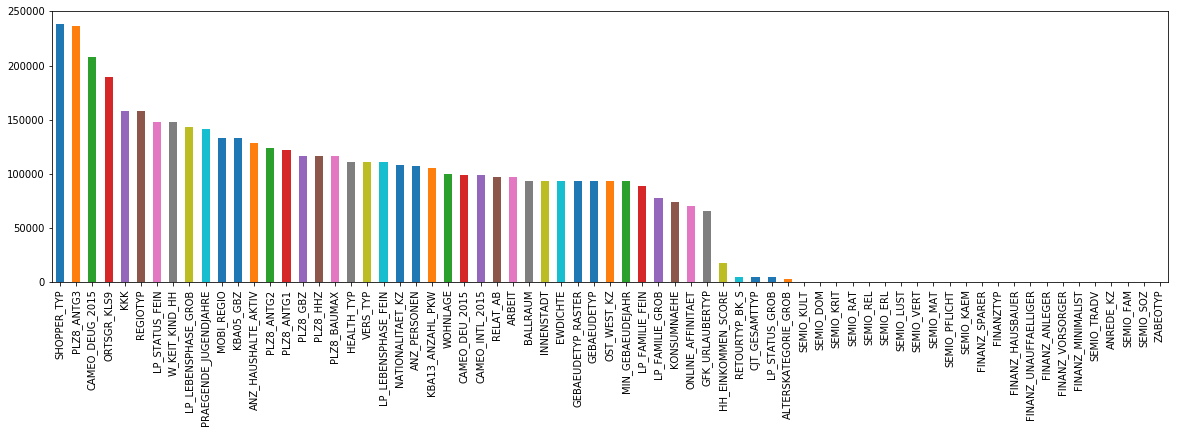

In [27]:
# null values after removing the outliers - there is some more room to remove the top four features which are missing values

azdias.isnull()[null_columns].sum().sort_values(ascending = False).plot.bar(figsize=(20,5))

In [28]:
# 69 features selected after imputing null values

azd = azdias[null_columns]
azd.shape

(891221, 69)

#### Discussion 1.1.2: Assess Missing Data in Each Column

###### Tier 1: (of missing data)

###### TITEL_KZ                 0.997576
###### ANZ_TITEL                0.996432
###### SOHO_KZ                  0.992271
###### ANZ_HH_TITEL             0.973144

Almost all the data was missing in these columns since these are title columns so these columns were removed from the computation.

###### Tier 2: (of missing data) 

###### KBA05_ANTG4              0.823023
###### GREEN_AVANTGARDE         0.803388
###### AGER_TYP                 0.769554
###### KBA05_ANTG3              0.723579
###### WOHNDAUER_2008           0.700920
###### KK_KUNDENTYP             0.655967
###### KBA05_BAUMAX             0.534687
###### PLZ8_ANTG4               0.530625
###### KBA05_ANTG2              0.477841
###### KBA05_ANTG1              0.442509
###### GEBURTSJAHR              0.440203
###### ALTER_HH                 0.373739

We removed all the columns that were missing more than 35% of the data to maintain accuracy in the predictions we will perform soon. These columns were also removed from the dataset.

If you observe the plot above:

###### Tier 3: (of acceptable missing data)

###### SHOPPER_TYP              0.267922
###### PLZ8_ANTG3               0.265152
###### CAMEO_DEUG_2015          0.232859
###### ORTSGR_KLS9              0.212240

These columns seem like spikes in the null data bar plot, but we have kept them since this is the far most amount of missing data that we want to keep for our compuations. And this will be a reasonable.

The rest of the columns seem to be in the reasonable range, missing data almost the same amount as any other column in the dataset.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [29]:
# How much data is missing in each row of the dataset?
azd = azdias[null_columns]
row_miss_data = azd.isnull().sum(axis = 1).sort_values(ascending = False)
row_miss_data

732775    43
643174    43
472919    42
281305    39
613253    39
392456    39
161480    39
80444     39
469054    39
547468    39
141404    39
58254     39
227757    39
814046    39
15284     39
826869    39
15680     39
537799    39
212053    39
170081    39
174378    39
451655    39
441673    38
281060    38
712717    38
367064    38
712721    38
281062    38
281090    38
712601    38
          ..
653684     0
653685     0
653686     0
653688     0
653649     0
449530     0
148724     0
148725     0
449547     0
653613     0
653614     0
276126     0
148749     0
148748     0
653618     0
449544     0
148744     0
148741     0
276131     0
653627     0
449537     0
148737     0
148736     0
653629     0
276133     0
148732     0
148729     0
148727     0
653642     0
617493     0
Length: 891221, dtype: int64

In [30]:
row_miss_data/azd.shape[1] > .35

732775     True
643174     True
472919     True
281305     True
613253     True
392456     True
161480     True
80444      True
469054     True
547468     True
141404     True
58254      True
227757     True
814046     True
15284      True
826869     True
15680      True
537799     True
212053     True
170081     True
174378     True
451655     True
441673     True
281060     True
712717     True
367064     True
712721     True
281062     True
281090     True
712601     True
          ...  
653684    False
653685    False
653686    False
653688    False
653649    False
449530    False
148724    False
148725    False
449547    False
653613    False
653614    False
276126    False
148749    False
148748    False
653618    False
449544    False
148744    False
148741    False
276131    False
653627    False
449537    False
148737    False
148736    False
653629    False
276133    False
148732    False
148729    False
148727    False
653642    False
617493    False
Length: 891221, dtype: b

In [31]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

miss_data_100_35 = row_miss_data/azd.shape[1] > .35

miss_data_34_0 = row_miss_data/azd.shape[1] < .35


#total_null_rows = (azdias.isnull().sum()/azdias.shape[0]).sort_values(ascending = False).index.tolist()
null_rows = []
for i,value in enumerate(miss_data_34_0):
    if value == True:
        null_rows.append(row_miss_data[i])
        

print(null_rows) 

[0, 1, 0, 1, 0, 2, 5, 2, 0, 1, 2, 3, 2, 28, 2, 2, 8, 1, 1, 6, 0, 1, 3, 0, 2, 2, 1, 1, 1, 3, 0, 8, 2, 1, 27, 9, 3, 2, 2, 1, 6, 1, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 0, 28, 0, 7, 1, 2, 3, 0, 29, 0, 8, 1, 2, 1, 6, 1, 1, 1, 0, 2, 13, 3, 1, 1, 0, 2, 1, 2, 3, 2, 0, 2, 3, 6, 6, 1, 3, 3, 0, 3, 1, 6, 4, 5, 1, 0, 1, 0, 9, 6, 1, 28, 0, 0, 4, 3, 1, 0, 1, 1, 0, 4, 6, 1, 1, 7, 0, 2, 6, 3, 1, 0, 5, 6, 2, 1, 1, 0, 4, 1, 1, 1, 4, 0, 2, 3, 6, 2, 2, 1, 1, 2, 3, 1, 0, 1, 2, 3, 1, 0, 1, 1, 0, 3, 7, 4, 6, 1, 29, 1, 3, 1, 1, 1, 1, 1, 3, 0, 0, 1, 7, 0, 0, 0, 3, 0, 3, 29, 1, 28, 1, 2, 6, 1, 17, 1, 1, 7, 1, 2, 1, 1, 2, 1, 0, 7, 0, 1, 2, 2, 2, 3, 8, 1, 2, 2, 1, 3, 3, 1, 0, 1, 2, 0, 1, 9, 2, 2, 1, 28, 0, 0, 1, 4, 1, 4, 0, 28, 1, 0, 4, 1, 8, 0, 1, 1, 1, 4, 0, 1, 3, 0, 2, 3, 0, 2, 1, 6, 0, 1, 2, 3, 35, 1, 18, 2, 1, 2, 2, 2, 1, 38, 0, 0, 38, 1, 1, 0, 0, 6, 1, 0, 0, 0, 8, 1, 2, 2, 2, 1, 0, 1, 2, 3, 2, 4, 1, 3, 1, 0, 1, 2, 11, 2, 1, 2, 3, 1, 0, 2, 1, 1, 1, 8, 0, 2, 1, 6, 2, 1, 0, 6, 0, 0, 2, 0, 6, 27, 2, 0, 1, 0, 

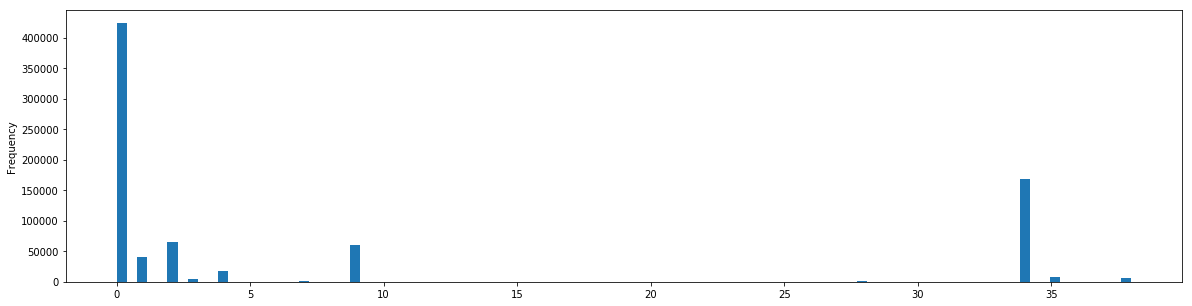

In [32]:
(row_miss_data[null_rows])
row_miss_data[null_rows].plot(kind='hist',bins = 100, figsize = (20,5))


In [33]:
row_miss_data[row_miss_data/azd.shape[1] < .35]

835622    24
244327    24
596416    24
263997    24
547289    24
528568    23
424359    23
333297    23
125820    23
1044      23
605870    23
634000    23
775008    23
772199    23
179060    23
135117    23
602921    23
463153    23
246926    23
881413    23
842154    23
731185    23
591584    23
818783    23
208248    23
601889    23
450026    23
86430     22
58926     22
411378    22
          ..
653684     0
653685     0
653686     0
653688     0
653649     0
449530     0
148724     0
148725     0
449547     0
653613     0
653614     0
276126     0
148749     0
148748     0
653618     0
449544     0
148744     0
148741     0
276131     0
653627     0
449537     0
148737     0
148736     0
653629     0
276133     0
148732     0
148729     0
148727     0
653642     0
617493     0
Length: 798049, dtype: int64

In [34]:
azd.ix[835622].isnull().sum()

C:\Users\Wrangler\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


24

In [35]:

row_miss_data[row_miss_data/azd.shape[1] < .35].index.tolist()[:10]

[835622, 244327, 596416, 263997, 547289, 528568, 424359, 333297, 125820, 1044]

In [36]:
#azd[azd[5:11].isin(row_miss_data[row_miss_data/azd.shape[1] < .35].index.tolist())]
azd.ix[row_miss_data[row_miss_data/azd.shape[1] < .35].index.tolist()]

C:\Users\Wrangler\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,SHOPPER_TYP,PLZ8_ANTG3,CAMEO_DEUG_2015,ORTSGR_KLS9,KKK,REGIOTYP,LP_STATUS_FEIN,W_KEIT_KIND_HH,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,...,SEMIO_DOM,SEMIO_KRIT,SEMIO_RAT,SEMIO_KULT,SEMIO_ERL,SEMIO_LUST,SEMIO_VERT,SEMIO_MAT,SEMIO_REL,ZABEOTYP
835622,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,6,7,4,3,3,5,1,5,7,3
244327,1.0,NaN,NaN,5.0,NaN,NaN,NaN,3.0,NaN,8.0,...,2,5,5,5,4,4,7,6,4,1
596416,3.0,NaN,NaN,4.0,NaN,NaN,NaN,6.0,NaN,15.0,...,6,7,6,3,4,2,1,4,5,3
263997,3.0,NaN,NaN,5.0,NaN,NaN,NaN,3.0,NaN,14.0,...,6,7,6,3,5,2,4,7,5,5
547289,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,6,7,4,3,3,5,1,5,7,3
528568,3.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,3.0,...,6,7,4,2,7,5,4,4,4,3
424359,NaN,NaN,NaN,5.0,3.0,4.0,NaN,3.0,NaN,8.0,...,2,5,2,5,4,4,7,1,4,3
333297,3.0,NaN,NaN,4.0,2.0,4.0,NaN,6.0,NaN,NaN,...,3,3,1,4,7,5,7,4,2,3
125820,NaN,NaN,NaN,2.0,NaN,NaN,8.0,NaN,NaN,NaN,...,6,7,4,3,3,5,1,5,7,1
1044,3.0,NaN,4,5.0,NaN,NaN,NaN,6.0,NaN,NaN,...,6,7,4,2,7,5,4,4,4,3


In [37]:
less_nulls = azdias[azdias.isnull().sum(axis=1)< 25 ]
more_nulls = azdias[azdias.isnull().sum(axis=1)> 25 ]

less_nulls[less_nulls.columns[0]]

1         NaN
2         NaN
3         2.0
4         NaN
5         3.0
6         NaN
7         NaN
8         NaN
9         NaN
10        NaN
12        NaN
13        NaN
15        1.0
16        NaN
18        NaN
19        NaN
20        NaN
21        NaN
22        NaN
23        NaN
25        NaN
27        NaN
28        NaN
29        2.0
31        NaN
32        NaN
33        NaN
34        3.0
36        NaN
37        2.0
         ... 
891190    2.0
891191    1.0
891192    NaN
891193    2.0
891194    NaN
891195    2.0
891196    NaN
891197    NaN
891198    NaN
891199    NaN
891200    NaN
891201    NaN
891202    NaN
891204    NaN
891205    1.0
891206    NaN
891207    1.0
891208    NaN
891209    NaN
891210    NaN
891211    NaN
891212    NaN
891213    NaN
891214    NaN
891215    NaN
891216    NaN
891217    NaN
891218    NaN
891219    NaN
891220    NaN
Name: AGER_TYP, Length: 790203, dtype: float64

C:\Users\Wrangler\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Wrangler\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


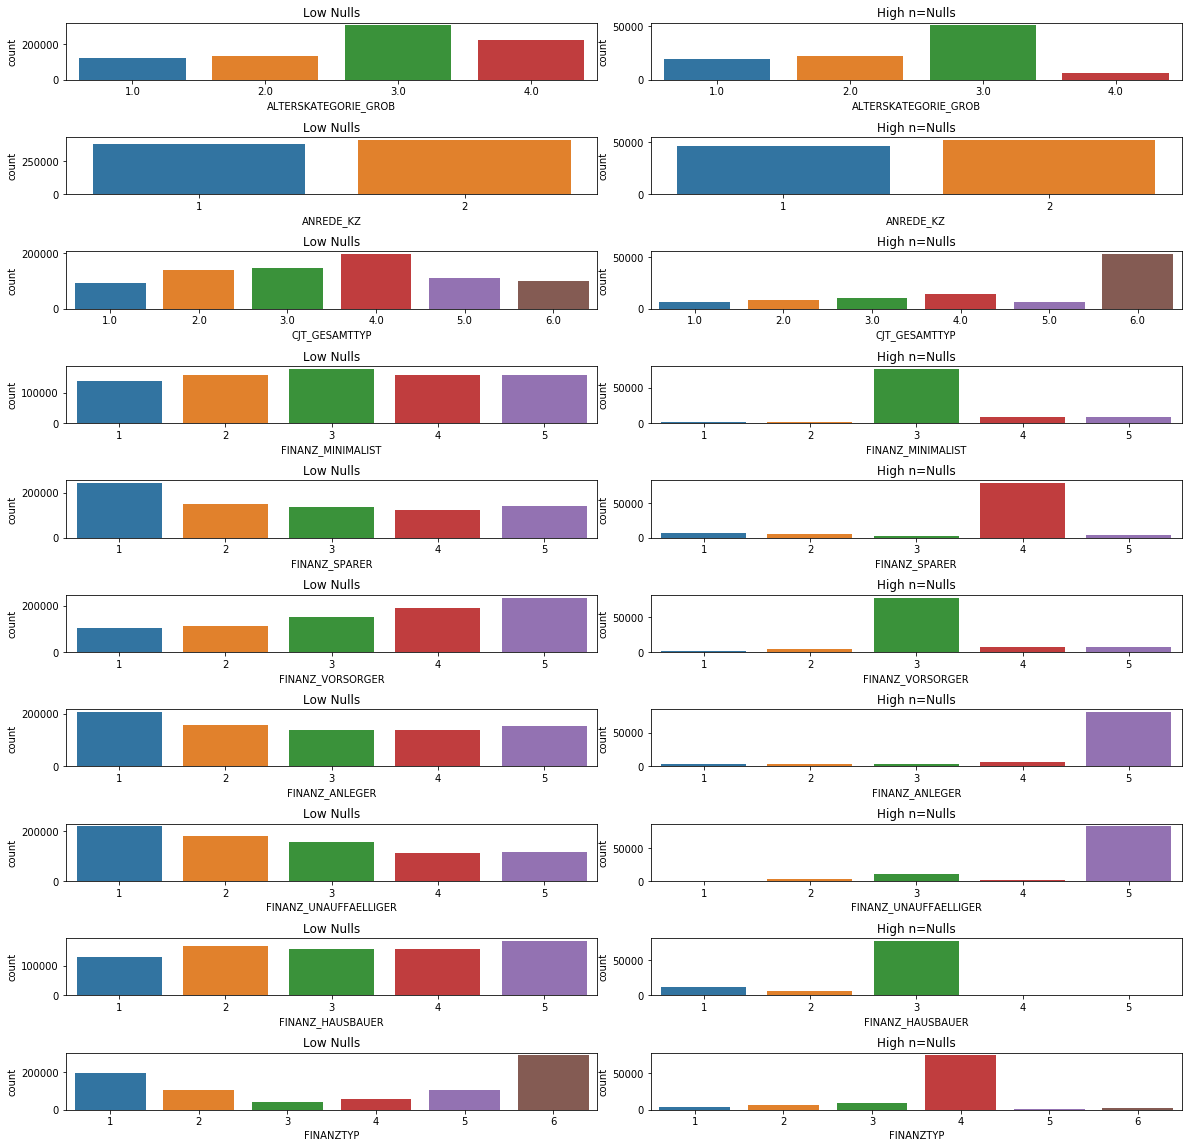

In [38]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
less_nulls = azdias[azdias.isnull().sum(axis=1).sort_values(ascending = False)< 25 ]
more_nulls = azdias[azdias.isnull().sum(axis=1).sort_values(ascending = False)> 25 ]

cols_1 = less_nulls.columns

figure, axis = plt.subplots(10,2, figsize=(20, 20),)
figure.subplots_adjust(hspace =1 , wspace=.1)
axis = axis.ravel()

for n,col in enumerate(cols_1[1:11]):
    
    sns.countplot(less_nulls[col], ax =axis[n*2])
    axis[n*2].set_title('Low Nulls')
        
    sns.countplot(more_nulls[col], ax =axis[n*2+1])
    axis[n*2+1].set_title('High n=Nulls')

In [39]:
# ratio of nulls to the entire imputed and filtered data set to nulls less than 35%
original_nulls = np.sum(azdias.isnull().as_matrix())
all_nulls = np.sum(azd.isnull().as_matrix())
all_nulls/(azd.shape[0]*azd.shape[1])

print("# of nulls: Before filtering",original_nulls)
print("Ratio before filtering: ", original_nulls/(azd.shape[0]*azd.shape[1]))
print(" Total Data Set: ", azd.shape)
print("Total Nulls in the data set: ", all_nulls)
print("Ratio of nulls to the total cells of the data set: ", all_nulls/(azd.shape[0]*azd.shape[1]))

C:\Users\Wrangler\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


# of nulls: Before filtering 14988198
Ratio before filtering:  0.24373332862394986
 Total Data Set:  (891221, 69)
Total Nulls in the data set:  4974922
Ratio of nulls to the total cells of the data set:  0.08090060584364564


C:\Users\Wrangler\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

We are observing the imputed dataset.
The Low Nulls contains data containing less than 35% null values and High Nulls contain data containing more than 35% of null values.

The distribution of the data sets suggest that we may need it will be reasaonable to impute the data with the mode of each column, since there is only 8% null data in the entire filtered dat set.

The predictions will be reasonable after imputing the data set.

Looking at the histographs it seems there is only one or two values in each of the columns that have null values. Each column still contains a rich amount of large amount of other values to evalute the results after imputing it with the mode of each column. 

In [40]:
#imputing the null data with the feature mode

less_nulls_imputed = less_nulls.copy(deep = True)
cols_1_imputed = less_nulls_imputed.columns
for col_1 in cols_1_imputed:
    less_nulls_imputed[col_1] = less_nulls_imputed[col_1].fillna(less_nulls_imputed[col_1].mode()[0])

less_nulls_imputed

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,2.0,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,2.0,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,1.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,1.0,1.0,3.0,4.0,2.0,3.0,3.0
4,2.0,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,1.0,1.0,5.0,5.0,4.0,6.0,3.0
7,2.0,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,1.0,1.0,4.0,4.0,2.0,5.0,2.0
8,2.0,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,2.0,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,2.0,3.0,2,1.0,2,2,5,3,1,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [41]:
# all the data imputed with the feature mode in data set containing less than 35% null values

less_nulls_imputed.isnull().sum()

AGER_TYP                 0
ALTERSKATEGORIE_GROB     0
ANREDE_KZ                0
CJT_GESAMTTYP            0
FINANZ_MINIMALIST        0
FINANZ_SPARER            0
FINANZ_VORSORGER         0
FINANZ_ANLEGER           0
FINANZ_UNAUFFAELLIGER    0
FINANZ_HAUSBAUER         0
FINANZTYP                0
GEBURTSJAHR              0
GFK_URLAUBERTYP          0
GREEN_AVANTGARDE         0
HEALTH_TYP               0
LP_LEBENSPHASE_FEIN      0
LP_LEBENSPHASE_GROB      0
LP_FAMILIE_FEIN          0
LP_FAMILIE_GROB          0
LP_STATUS_FEIN           0
LP_STATUS_GROB           0
NATIONALITAET_KZ         0
PRAEGENDE_JUGENDJAHRE    0
RETOURTYP_BK_S           0
SEMIO_SOZ                0
SEMIO_FAM                0
SEMIO_REL                0
SEMIO_MAT                0
SEMIO_VERT               0
SEMIO_LUST               0
                        ..
OST_WEST_KZ              0
WOHNLAGE                 0
CAMEO_DEUG_2015          0
CAMEO_DEU_2015           0
CAMEO_INTL_2015          0
KBA05_ANTG1              0
K

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [42]:
# How many features are there of each data type?

data_type = feat_info['type'].unique().tolist()
print(data_type)
print(feat_info.columns)
print('\n')

for type in data_type:
    print('Data Type: ', type)
    print('\n Fetures: ',feat_info['attribute'][feat_info['type'] == type].tolist())
    print('\n # of Features: ', feat_info['attribute'][feat_info['type'] == type].shape[0])
    print("\n--------------------------------\n")

['categorical', 'ordinal', 'numeric', 'mixed', 'interval']
Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')


Data Type:  categorical

 Fetures:  ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

 # of Features:  21

--------------------------------

Data Type:  ordinal

 Fetures:  ['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'HH_EINKOMMEN_SCORE', 

In [43]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?


#print(feat_info['attribute'][feat_info['type'] == 'categorical'].as_matrix())
    
#print("\n--------------------------------\n")

cat_cols = feat_info['attribute'][feat_info['type'] == 'categorical' ]

for cat_col in cat_cols:
    for col_1 in cols_1_imputed:
        if cat_col == col_1:
            print(col_1)
            print(less_nulls_imputed[col_1].dtype)
            print(less_nulls_imputed[col_1].unique(), '\n')
            

AGER_TYP
float64
[2. 3. 1.] 

ANREDE_KZ
int64
[2 1] 

CJT_GESAMTTYP
float64
[5. 3. 2. 4. 1. 6.] 

FINANZTYP
int64
[1 6 5 2 4 3] 

GFK_URLAUBERTYP
float64
[10.  1.  5. 12.  3.  8. 11.  4.  7.  2.  6.] 

GREEN_AVANTGARDE
float64
[1.] 

LP_FAMILIE_FEIN
float64
[ 5.  1. 10.  2.  7. 11.  8.  4.  6.  3.] 

LP_FAMILIE_GROB
float64
[3. 1. 5. 2. 4.] 

LP_STATUS_FEIN
float64
[ 2.  3.  1.  4. 10.  5.  8.  6.  7.] 

LP_STATUS_GROB
float64
[1. 2. 4. 5. 3.] 

NATIONALITAET_KZ
float64
[1. 3. 2.] 

SHOPPER_TYP
float64
[3. 2. 1.] 

SOHO_KZ
float64
[1.] 

TITEL_KZ
float64
[1. 4. 3. 5. 2.] 

VERS_TYP
float64
[2. 1.] 

ZABEOTYP
int64
[5 3 4 1 6 2] 

KK_KUNDENTYP
float64
[3. 1. 6. 4. 2. 5.] 

GEBAEUDETYP
float64
[8. 1. 3. 2. 6. 4. 5.] 

OST_WEST_KZ
object
['W' 'O'] 

CAMEO_DEUG_2015
object
['8' '4' '2' '6' '1' '5' '7' '3'] 

CAMEO_DEU_2015
object
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D'

In [45]:
# Re-encode categorical variable(s) to be kept in the analysis.
less_nulls_encoded = less_nulls_imputed.copy(deep = True)
cat_bag = []

for cat_col in cat_cols:
    for col_1 in cols_1_imputed:
        if cat_col == col_1:
            #print('\n',col_1)
            if (len(less_nulls_encoded[col_1].unique()) == 2 and 
            ( less_nulls_encoded[col_1].dtype == 'object' or (less_nulls_encoded[col_1].dtype) == 'float64')):
                
                #less_nulls[col_1] = pd.get_dummies(less_nulls_encoded[col_1])
                print(col_1)
                print(less_nulls_encoded[col_1].unique())
                print(less_nulls_encoded[col_1].dtype)
                cat_bag.append(col_1)
               
            if (less_nulls_encoded[col_1].dtype) == 'object':
                print(col_1)
                print(less_nulls_encoded[col_1].unique())
                print(less_nulls_encoded[col_1].dtype)
                #less_nulls_encoded[col_1] = pd.get_dummies(less_nulls_encoded[col_1])
                print(less_nulls_encoded[col_1].unique())
                print(less_nulls_encoded[col_1].dtype)
                cat_bag.append(col_1)
                
print(cat_bag, '\n\n')

less_nulls_encoded = pd.get_dummies(data = less_nulls_encoded, columns = cat_bag)
encoded = list(less_nulls_encoded.columns)
                
print("{} total features after one-hot encoding.".format(len(encoded)))

# the encoded feature names
print(encoded)

VERS_TYP
[2. 1.]
float64
OST_WEST_KZ
['W' 'O']
object
OST_WEST_KZ
['W' 'O']
object
['W' 'O']
object
CAMEO_DEUG_2015
['8' '4' '2' '6' '1' '5' '7' '3']
object
['8' '4' '2' '6' '1' '5' '7' '3']
object
CAMEO_DEU_2015
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
object
['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C']
object
['VERS_TYP', 'OST_WEST_KZ', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] 


139 total features after one-hot encoding.
['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTY

In [46]:
#categorical columns Hot-Encoded!

cat_cols = feat_info['attribute'][feat_info['type'] == 'categorical' ]

for col_1 in encoded:
    print(col_1)
    print(less_nulls_encoded[col_1].dtype)
    print(less_nulls_encoded[col_1].unique(), '\n')

AGER_TYP
float64
[2. 3. 1.] 

ALTERSKATEGORIE_GROB
float64
[1. 3. 4. 2.] 

ANREDE_KZ
int64
[2 1] 

CJT_GESAMTTYP
float64
[5. 3. 2. 4. 1. 6.] 

FINANZ_MINIMALIST
int64
[1 4 3 2 5] 

FINANZ_SPARER
int64
[5 4 2 3 1] 

FINANZ_VORSORGER
int64
[2 1 5 4 3] 

FINANZ_ANLEGER
int64
[5 2 1 4 3] 

FINANZ_UNAUFFAELLIGER
int64
[4 3 1 2 5] 

FINANZ_HAUSBAUER
int64
[5 2 3 4 1] 

FINANZTYP
int64
[1 6 5 2 4 3] 

GEBURTSJAHR
float64
[1996. 1979. 1957. 1963. 1943. 1967. 1964. 1974. 1975. 1941. 1993. 1946.
 1988. 1991. 1966. 1949. 1982. 1972. 1990. 1985. 1989. 1948. 1935. 1997.
 1994. 1987. 2002. 1950. 1965. 1969. 1978. 1958. 1944. 1977. 1960. 1970.
 1973. 1971. 1937. 1947. 1926. 1954. 1981. 1962. 1992. 2008. 1976. 1928.
 1927. 1968. 1940. 1952. 1961. 2006. 1938. 1945. 1942. 1984. 1930. 1980.
 1959. 1986. 1931. 1955. 1983. 2010. 1951. 1921. 1929. 1939. 2001. 1995.
 1956. 1953. 2012. 1934. 1913. 1914. 1922. 2004. 1936. 2009. 2003. 2013.
 1998. 2007. 1932. 2005. 1923. 1925. 1933. 2017. 2000. 1999. 2014. 1920

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [47]:
less_nulls_encoded['OST_WEST_KZ_O']

,OST_WEST_KZ_O,OST_WEST_KZ_O
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0
10,0,0


In [48]:
# Dropping all erronious feature
less_nulls_encoded.drop(['OST_WEST_KZ_O','OST_WEST_KZ_W'], axis =1, inplace = True)

In [49]:
#categorical columns Hot-Encoded!
encoded_revised = list(less_nulls_encoded.columns)
cat_cols = feat_info['attribute'][feat_info['type'] == 'categorical' ]

for col_1 in encoded_revised:
    print(col_1)
    print(less_nulls_encoded[col_1].dtype)
    print(less_nulls_encoded[col_1].unique(), '\n')

AGER_TYP
float64
[2. 3. 1.] 

ALTERSKATEGORIE_GROB
float64
[1. 3. 4. 2.] 

ANREDE_KZ
int64
[2 1] 

CJT_GESAMTTYP
float64
[5. 3. 2. 4. 1. 6.] 

FINANZ_MINIMALIST
int64
[1 4 3 2 5] 

FINANZ_SPARER
int64
[5 4 2 3 1] 

FINANZ_VORSORGER
int64
[2 1 5 4 3] 

FINANZ_ANLEGER
int64
[5 2 1 4 3] 

FINANZ_UNAUFFAELLIGER
int64
[4 3 1 2 5] 

FINANZ_HAUSBAUER
int64
[5 2 3 4 1] 

FINANZTYP
int64
[1 6 5 2 4 3] 

GEBURTSJAHR
float64
[1996. 1979. 1957. 1963. 1943. 1967. 1964. 1974. 1975. 1941. 1993. 1946.
 1988. 1991. 1966. 1949. 1982. 1972. 1990. 1985. 1989. 1948. 1935. 1997.
 1994. 1987. 2002. 1950. 1965. 1969. 1978. 1958. 1944. 1977. 1960. 1970.
 1973. 1971. 1937. 1947. 1926. 1954. 1981. 1962. 1992. 2008. 1976. 1928.
 1927. 1968. 1940. 1952. 1961. 2006. 1938. 1945. 1942. 1984. 1930. 1980.
 1959. 1986. 1931. 1955. 1983. 2010. 1951. 1921. 1929. 1939. 2001. 1995.
 1956. 1953. 2012. 1934. 1913. 1914. 1922. 2004. 1936. 2009. 2003. 2013.
 1998. 2007. 1932. 2005. 1923. 1925. 1933. 2017. 2000. 1999. 2014. 1920

In [50]:
less_nulls_encoded.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,2.0,1.0,2,5.0,1,5,2,5,4,5,...,0,1,0,0,0,0,0,0,0,0
2,2.0,3.0,2,3.0,1,4,1,2,3,5,...,0,0,0,0,0,0,0,0,0,0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,0,0,0,0,0,0,0,0,0,0
4,2.0,3.0,1,5.0,4,3,4,1,3,2,...,0,0,0,0,0,0,0,0,0,0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,0,0,0,1,0,0,0,0,0,0


In [51]:
print("Number of columns before imputing with mode of the features and hot encodeing")
print(less_nulls.shape, '\n')
print("Number of columns after imputing with mode of the feature and hot encoding")
print(less_nulls_encoded.shape)

Number of columns before imputing with mode of the features and hot encodeing
(790203, 85) 

Number of columns after imputing with mode of the feature and hot encoding
(790203, 135)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There were two features which were erronious and I dropped them from the data set:
1) 'OST_WEST_KZ_O',
2) 'OST_WEST_KZ_W'

I imputed the data set containing less than 35% null values and then hot encoded it.
The number of columns jumped from 85 to 135.

The hot encoded features where :
1) 'VERS_TYP', 
2) 'OST_WEST_KZ',
3) 'OST_WEST_KZ', 
4) 'CAMEO_DEUG_2015', 
5) 'CAMEO_DEU_2015'

Out of which 2 and 3 were dropped since thier data set was bias.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [69]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
df_pj_1 = less_nulls_encoded.copy(deep= True)
df_pj = df_pj_1["PRAEGENDE_JUGENDJAHRE"]
print(df_pj.sum())
print(df_pj.unique())
print(df_pj.describe())
print(df_pj.value_counts().sort_values(ascending=False)/df_pj.shape[0])
print(df_pj.mean())
print(df_pj.std())
print(df_pj.mode())
print(df_pj.isnull().sum())

#mean(abs(x - x.mean())**2)

#var_1 = np.mean(np.abs(df_pj.unique()[3] - df_pj.mean())**2)

#print(var_1)

7620867.0
[14. 15.  8.  3. 10. 11.  5.  6.  4.  2.  1. 12. 13.  7.]
count    790203.000000
mean          9.644189
std           4.151147
min           1.000000
25%           6.000000
50%          10.000000
75%          14.000000
max          15.000000
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
14.0    0.305389
8.0     0.177362
10.0    0.107628
5.0     0.106727
3.0     0.067785
15.0    0.053401
11.0    0.044939
6.0     0.032449
12.0    0.030726
1.0     0.025979
4.0     0.025860
2.0     0.009457
13.0    0.007235
7.0     0.005062
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
9.644188898295754
4.15114704521664
0    14.0
dtype: float64
0


In [70]:
df_pj[df_pj.value_counts().sort_values(ascending=False)/df_pj.sum()] > .2

PRAEGENDE_JUGENDJAHRE
0.031666    False
0.018391    False
0.011160    False
0.011066    False
0.007029    False
0.005537    False
0.004660    False
0.003365    False
0.003186    False
0.002694    False
0.002681    False
0.000981    False
0.000750    False
0.000525    False
Name: PRAEGENDE_JUGENDJAHRE, dtype: bool

In [71]:
df_pj_values = df_pj.values
df_pj_values

array([14., 15.,  8., ..., 14., 14.,  3.])

In [72]:
df_pj_1["Altersjahr Abweichung"] = pd.Series(df_pj_values - df_pj.mean(), index = df_pj_1.index)
#df_pj.drop("Teenager-Mehrheitsjahr", axis = 1, inplace = True)
#df_pj_1["Altersjahr Abweichung"].shape

In [73]:
#print(df_pj["Teenager-Mehrheitsjahr"].shape)
df_pj_1["Altersjahr Abweichung"]
#df_pj.drop('Altersjahr Abweichung', axis = 1, inplace = True)

1         4.355811
2         5.355811
3        -1.644189
4        -1.644189
5        -6.644189
6         0.355811
7        -1.644189
8         1.355811
9         5.355811
10       -6.644189
12       -1.644189
13        5.355811
15       -4.644189
16        4.355811
18        0.355811
19        4.355811
20        1.355811
21        0.355811
22        4.355811
23        4.355811
25        4.355811
27        1.355811
28        0.355811
29       -3.644189
31        0.355811
32        5.355811
33       -1.644189
34       -5.644189
36       -1.644189
37       -1.644189
            ...   
891190   -5.644189
891191   -6.644189
891192    4.355811
891193   -4.644189
891194    1.355811
891195   -1.644189
891196    4.355811
891197    1.355811
891198    5.355811
891199    0.355811
891200    4.355811
891201    0.355811
891202    0.355811
891204    0.355811
891205   -6.644189
891206    4.355811
891207   -7.644189
891208   -1.644189
891209    4.355811
891210   -1.644189
891211   -1.644189
891212   -6.

In [74]:
df_pj_1['PRAEGENDE_JUGENDJAHRE']

1         14.0
2         15.0
3          8.0
4          8.0
5          3.0
6         10.0
7          8.0
8         11.0
9         15.0
10         3.0
12         8.0
13        15.0
15         5.0
16        14.0
18        10.0
19        14.0
20        11.0
21        10.0
22        14.0
23        14.0
25        14.0
27        11.0
28        10.0
29         6.0
31        10.0
32        15.0
33         8.0
34         4.0
36         8.0
37         8.0
          ... 
891190     4.0
891191     3.0
891192    14.0
891193     5.0
891194    11.0
891195     8.0
891196    14.0
891197    11.0
891198    15.0
891199    10.0
891200    14.0
891201    10.0
891202    10.0
891204    10.0
891205     3.0
891206    14.0
891207     2.0
891208     8.0
891209    14.0
891210     8.0
891211     8.0
891212     3.0
891213    11.0
891214    14.0
891215    10.0
891216    14.0
891217    10.0
891218    14.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 790203, dtype: float64

In [363]:
'''
def age_density(pj_value):
    if df_pj[df_pj.value_counts().sort_values(ascending=False)/df_pj.sum()] > .2:
        #less_nulls_encoded["Teenager-Mehrheitsjahr"] = df_pj_1['PRAEGENDE_JUGENDJAHRE'].apply(2)
        return 2
    
    if (df_pj[df_pj.value_counts().sort_values(ascending=False)/df_pj.sum()] < .2 and 
        df_pj[df_pj.value_counts().sort_values(ascending=False)/df_pj.sum()] > .1):
        #less_nulls_encoded["Teenager-Mehrheitsjahr"] = less_nulls_encoded["PRAEGENDE_JUGENDJAHRE"].apply(1)
        return 1
    
    if df_pj[df_pj.value_counts().sort_values(ascending=False)/df_pj.sum()] < .1:
        #less_nulls_encoded["Teenager-Mehrheitsjahr"] = less_nulls_encoded["PRAEGENDE_JUGENDJAHRE"].apply(0)
        return 0
    
def var_from_mean_average(pj_value):
    if df_pj_1["Altersjahr Abweichung"] > df_pj.std:
        #less_nulls_encoded["Teenager-Mehrheitsjahr"] = less_nulls_encoded["PRAEGENDE_JUGENDJAHRE"].apply(2)
        return 2
        
    if (df_pj_1["Altersjahr Abweichung"] <= df_pj.std and 
        df_pj_1["Altersjahr Abweichung"] > -df_pj.std):
        #less_nulls_encoded["Teenager-Mehrheitsjahr"] = less_nulls_encoded["PRAEGENDE_JUGENDJAHRE"].apply(1)
        return 1
        
    if df_pj_1["Altersjahr Abweichung"] <= -df_pj.std:
        #less_nulls_encoded["Teenager-Mehrheitsjahr"] = less_nulls_encoded["PRAEGENDE_JUGENDJAHRE"].apply(0)
        return 0
'''

'\ndef age_density(pj_value):\n    if df_pj[df_pj.value_counts().sort_values(ascending=False)/df_pj.sum()] > .2:\n        #less_nulls_encoded["Teenager-Mehrheitsjahr"] = df_pj_1[\'PRAEGENDE_JUGENDJAHRE\'].apply(2)\n        return 2\n    \n    if (df_pj[df_pj.value_counts().sort_values(ascending=False)/df_pj.sum()] < .2 and \n        df_pj[df_pj.value_counts().sort_values(ascending=False)/df_pj.sum()] > .1):\n        #less_nulls_encoded["Teenager-Mehrheitsjahr"] = less_nulls_encoded["PRAEGENDE_JUGENDJAHRE"].apply(1)\n        return 1\n    \n    if df_pj[df_pj.value_counts().sort_values(ascending=False)/df_pj.sum()] < .1:\n        #less_nulls_encoded["Teenager-Mehrheitsjahr"] = less_nulls_encoded["PRAEGENDE_JUGENDJAHRE"].apply(0)\n        return 0\n    \ndef var_from_mean_average(pj_value):\n    if df_pj_1["Altersjahr Abweichung"] > df_pj.std:\n        #less_nulls_encoded["Teenager-Mehrheitsjahr"] = less_nulls_encoded["PRAEGENDE_JUGENDJAHRE"].apply(2)\n        return 2\n        \n    if 

In [75]:
df_pj_test = df_pj_1.copy(deep = True)
print(df_pj_test['PRAEGENDE_JUGENDJAHRE'].value_counts())
print(df_pj_test['PRAEGENDE_JUGENDJAHRE'].isnull().sum())

df_pj_test["Teenager-Mehrheitsjahr"] = pd.Series(df_pj_test['PRAEGENDE_JUGENDJAHRE'].values, index = df_pj_test.index)

print(df_pj_test["Teenager-Mehrheitsjahr"].value_counts())

14.0    241319
8.0     140152
10.0     85048
5.0      84336
3.0      53564
15.0     42198
11.0     35511
6.0      25641
12.0     24280
1.0      20529
4.0      20435
2.0       7473
13.0      5717
7.0       4000
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
0
14.0    241319
8.0     140152
10.0     85048
5.0      84336
3.0      53564
15.0     42198
11.0     35511
6.0      25641
12.0     24280
1.0      20529
4.0      20435
2.0       7473
13.0      5717
7.0       4000
Name: Teenager-Mehrheitsjahr, dtype: int64


In [76]:

#df_pj[df_pj.value_counts().sort_values(ascending=False)/df_pj.sum()] > .2
print(df_pj.value_counts())
print(df_pj.value_counts()/df_pj.shape[0])
print((df_pj.value_counts()/df_pj.shape[0]).index.tolist())
print((df_pj.value_counts()/df_pj.shape[0] > .2).tolist(), '\n\n')
print((df_pj.value_counts()/df_pj.shape[0] < .2).tolist())
print((df_pj.value_counts()/df_pj.shape[0] > .1).tolist())

for bool_1 in (df_pj.value_counts()/df_pj.shape[0] > .2).tolist():
    print(bool_1)

def age_density(df):
    val_1 = (df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()
    print(val_1)
    
    for num,val in enumerate(val_1):
        if (df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0] > .2).tolist()[num] == True:
            #if bool_1 == True:
            print("area 1")
                #print(val)
                #print((df_pj.value_counts()/df_pj.shape[0]).index.tolist()[i])
            if val == (df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()[num]:
                print(val)
                print((df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()[num])
                df["Teenager-Mehrheitsjahr"] .replace(val,'aa-2', inplace = True)
                print(val , "2")
                #break
            

        if (df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0] < .2).tolist()[num] == True:
            #if bool_2 == True:
            print("area 2")
            if (df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0] > .1).tolist()[num] == True:
                if val == (df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()[num]:
                    print(val)
                    print((df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()[num])
                    df["Teenager-Mehrheitsjahr"] .replace(to_replace = val, value = 'aa-1', inplace = True)
                    print(val, "1")
                    #break
                    

        if (df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0] < .1).tolist()[num] == True:
            #if bool_3 == True:
            print("area 3")
            if val == (df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()[num]:
                print(val)
                print((df['PRAEGENDE_JUGENDJAHRE'].value_counts()/df['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()[num])
                df["Teenager-Mehrheitsjahr"] .replace(to_replace = val, value = 'aa-0', inplace = True)
                print(val, "0")
                #break
        print(df_pj_test["Teenager-Mehrheitsjahr"].value_counts())
    df["Teenager-Mehrheitsjahr"] .replace(to_replace = 'aa-2', value = 2, inplace = True)
    df["Teenager-Mehrheitsjahr"] .replace(to_replace = 'aa-1', value = 1, inplace = True)
    df["Teenager-Mehrheitsjahr"] .replace(to_replace = 'aa-0', value = 0, inplace = True)
        

14.0    241319
8.0     140152
10.0     85048
5.0      84336
3.0      53564
15.0     42198
11.0     35511
6.0      25641
12.0     24280
1.0      20529
4.0      20435
2.0       7473
13.0      5717
7.0       4000
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64
14.0    0.305389
8.0     0.177362
10.0    0.107628
5.0     0.106727
3.0     0.067785
15.0    0.053401
11.0    0.044939
6.0     0.032449
12.0    0.030726
1.0     0.025979
4.0     0.025860
2.0     0.009457
13.0    0.007235
7.0     0.005062
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
[14.0, 8.0, 10.0, 5.0, 3.0, 15.0, 11.0, 6.0, 12.0, 1.0, 4.0, 2.0, 13.0, 7.0]
[True, False, False, False, False, False, False, False, False, False, False, False, False, False] 


[False, True, True, True, True, True, True, True, True, True, True, True, True, True]
[True, True, True, True, False, False, False, False, False, False, False, False, False, False]
True
False
False
False
False
False
False
False
False
False
False
False
False
False


In [77]:
#df_pj_test = df_pj.copy(deep = True)

#df_pj_test["Teenager-Mehrheitsjahr"] = pd.Series(df_pj_test.values, index = df_pj_test.index)
age_density(df_pj_test)


[14.0, 8.0, 10.0, 5.0, 3.0, 15.0, 11.0, 6.0, 12.0, 1.0, 4.0, 2.0, 13.0, 7.0]
area 1
14.0
14.0
14.0 2
aa-2    241319
8.0     140152
10.0     85048
5.0      84336
3.0      53564
15.0     42198
11.0     35511
6.0      25641
12.0     24280
1.0      20529
4.0      20435
2.0       7473
13.0      5717
7.0       4000
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
8.0
8.0
8.0 1
aa-2    241319
aa-1    140152
10.0     85048
5.0      84336
3.0      53564
15.0     42198
11.0     35511
6.0      25641
12.0     24280
1.0      20529
4.0      20435
2.0       7473
13.0      5717
7.0       4000
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
10.0
10.0
10.0 1
aa-2    241319
aa-1    225200
5.0      84336
3.0      53564
15.0     42198
11.0     35511
6.0      25641
12.0     24280
1.0      20529
4.0      20435
2.0       7473
13.0      5717
7.0       4000
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
5.0
5.0
5.0 1
aa-1    309536
aa-2    241319
3.0      53564
15.0     42198
11.0     35511
6.0      25641

In [63]:
print(df_pj_test["Teenager-Mehrheitsjahr"].value_counts())

1    309536
2    241319
0    239348
Name: Teenager-Mehrheitsjahr, dtype: int64


In [64]:
df_pj_1["Altersjahr Abweichung"].value_counts()

 4.355811    241319
-1.644189    140152
 0.355811     85048
-4.644189     84336
-6.644189     53564
 5.355811     42198
 1.355811     35511
-3.644189     25641
 2.355811     24280
-8.644189     20529
-5.644189     20435
-7.644189      7473
 3.355811      5717
-2.644189      4000
Name: Altersjahr Abweichung, dtype: int64

In [67]:
df_pj_1["Teenager-Mehrheitsjahr"] = pd.Series(df_pj_test['PRAEGENDE_JUGENDJAHRE'].values, index = df_pj_test.index)

age_density(df_pj_1)

print(df_pj_1["Teenager-Mehrheitsjahr"].value_counts())

[14.0, 8.0, 10.0, 5.0, 3.0, 15.0, 11.0, 6.0, 12.0, 1.0, 4.0, 2.0, 13.0, 7.0]
area 1
14.0
14.0
14.0 2
1    309536
2    241319
0    239348
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
8.0
8.0
8.0 1
1    309536
2    241319
0    239348
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
10.0
10.0
10.0 1
1    309536
2    241319
0    239348
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
5.0
5.0
5.0 1
1    309536
2    241319
0    239348
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
area 3
3.0
3.0
3.0 0
1    309536
2    241319
0    239348
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
area 3
15.0
15.0
15.0 0
1    309536
2    241319
0    239348
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
area 3
11.0
11.0
11.0 0
1    309536
2    241319
0    239348
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
area 3
6.0
6.0
6.0 0
1    309536
2    241319
0    239348
Name: Teenager-Mehrheitsjahr, dtype: int64
area 2
area 3
12.0
12.0
12.0 0
1    309536
2    241319
0    239348
Name: Teenager-M

In [68]:
#df_pj_1.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [100]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
df_ci_1 = df_pj_1.copy(deep = True)


In [101]:
print(df_ci_1["CAMEO_INTL_2015"].value_counts())
print(df_ci_1["CAMEO_INTL_2015"].describe())
print(df_ci_1["CAMEO_INTL_2015"].unique())
print(len(df_ci_1["CAMEO_INTL_2015"].unique()))
print(df_ci_1["CAMEO_INTL_2015"].mode())

51    137331
41     91895
24     90539
14     62452
43     56401
54     45224
25     39335
22     32848
13     26104
45     26004
23     25844
55     23735
52     20437
31     18502
34     18419
15     16906
44     14738
12     13096
35     10292
32     10273
33      9828
Name: CAMEO_INTL_2015, dtype: int64
count     790203
unique        21
top           51
freq      137331
Name: CAMEO_INTL_2015, dtype: object
['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32']
21
0    51
dtype: object


In [103]:
# encoding cameo strings codes to integer cameo codes

ci_vals = df_ci_1["CAMEO_INTL_2015"].unique()
for ci_val in ci_vals:
    df_ci_1["CAMEO_INTL_2015"].replace(ci_val,int(ci_val), inplace = True)
    print(df_ci_1["CAMEO_INTL_2015"].value_counts())

51    137331
41     91895
24     90539
14     62452
43     56401
54     45224
25     39335
22     32848
13     26104
45     26004
23     25844
55     23735
52     20437
31     18502
34     18419
15     16906
44     14738
12     13096
35     10292
32     10273
33      9828
Name: CAMEO_INTL_2015, dtype: int64
51    137331
41     91895
24     90539
14     62452
43     56401
54     45224
25     39335
22     32848
13     26104
45     26004
23     25844
55     23735
52     20437
31     18502
34     18419
15     16906
44     14738
12     13096
35     10292
32     10273
33      9828
Name: CAMEO_INTL_2015, dtype: int64
51    137331
41     91895
24     90539
14     62452
43     56401
54     45224
25     39335
22     32848
13     26104
45     26004
23     25844
55     23735
52     20437
31     18502
34     18419
15     16906
44     14738
12     13096
35     10292
32     10273
33      9828
Name: CAMEO_INTL_2015, dtype: int64
51    137331
41     91895
24     90539
14     62452
43     56401
54     4

In [104]:
print(df_ci_1["CAMEO_INTL_2015"].value_counts())
print(df_ci_1["CAMEO_INTL_2015"].describe())
print(df_ci_1["CAMEO_INTL_2015"].unique())
print(len(df_ci_1["CAMEO_INTL_2015"].unique()))
print(df_ci_1["CAMEO_INTL_2015"].mode())

51    137331
41     91895
24     90539
14     62452
43     56401
54     45224
25     39335
22     32848
13     26104
45     26004
23     25844
55     23735
52     20437
31     18502
34     18419
15     16906
44     14738
12     13096
35     10292
32     10273
33      9828
Name: CAMEO_INTL_2015, dtype: int64
count    790203.000000
mean         35.606806
std          14.040529
min          12.000000
25%          24.000000
50%          41.000000
75%          51.000000
max          55.000000
Name: CAMEO_INTL_2015, dtype: float64
[51 24 12 43 54 22 14 13 15 33 41 34 55 25 23 31 52 35 45 44 32]
21
0    51
dtype: int64


In [105]:
# creating a cameo code tier feature
df_ci_1["CAMEO_INTL_TIER_2015"] = pd.Series(df_ci_1["CAMEO_INTL_2015"].values, index = df_ci_1.index)

In [109]:
ci_val_updated = df_ci_1["CAMEO_INTL_2015"].unique()

for ci_val in ci_val_updated:
    if ci_val >= 50:
        df_ci_1["CAMEO_INTL_TIER_2015"].replace(ci_val,5 , inplace = True)
    if ci_val < 50 and ci_val >= 40:
        df_ci_1["CAMEO_INTL_TIER_2015"].replace(ci_val,4 , inplace = True)
    if ci_val < 40 and ci_val >= 30:
        df_ci_1["CAMEO_INTL_TIER_2015"].replace(ci_val,3 , inplace = True)
    if ci_val < 30 and ci_val >= 20:
        df_ci_1["CAMEO_INTL_TIER_2015"].replace(ci_val,2 , inplace = True)
    if ci_val < 20 and ci_val >= 10:
        df_ci_1["CAMEO_INTL_TIER_2015"].replace(ci_val,1 , inplace = True)
    if ci_val < 10:
        df_ci_1["CAMEO_INTL_TIER_2015"].replace(ci_val,0 , inplace = True)

In [112]:
df_ci_1["CAMEO_INTL_TIER_2015"].value_counts()

5    226727
4    189038
2    188566
1    118558
3     67314
Name: CAMEO_INTL_TIER_2015, dtype: int64

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

For the PRAEGENDE_JUGENDJAHRE feature two new columns were created:
######### 1) Altersjahr Abweichung - Age variation from the mean age. The mean age is around 9 and the standard deviadtion is 4.
######### 2) Teenager-Mehrheitsjahr - Age density which is binary, and predicts about the frequency of a certain age.
These two operate along with PRAEGENDE_JUGENDJAHRE which basicaly means age and hence this column was kept in the data set.

CAMEO_INTL_2015 feature was updated from string to integer and hence has become more useable.
A second sub-feature was created to identify the tier level of the cameo code from 5 all the way up till 0.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [114]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
df_ci_1.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)


KeyError: "['PRAEGENDE_JUGENDJAHRE'] not found in axis"

In [118]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#all done!
print(df_ci_1.shape)
df_ci_1.head()


(790203, 136)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Altersjahr Abweichung,CAMEO_INTL_TIER_2015
1,2.0,1.0,2,5.0,1,5,2,5,4,5,...,0,0,0,0,0,0,0,0,4.355811,5
2,2.0,3.0,2,3.0,1,4,1,2,3,5,...,0,0,0,0,0,0,0,0,5.355811,2
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,0,0,0,0,0,0,0,0,-1.644189,1
4,2.0,3.0,1,5.0,4,3,4,1,3,2,...,0,0,0,0,0,0,0,0,-1.644189,4
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,0,1,0,0,0,0,0,0,-6.644189,5


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [25]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    miss_values = feat_info['missing_or_unknown']
    
    bag = []
    
    for df_column in df.columns:
        for miss_value in miss_values:
            for miss_val in miss_value[1:-1].strip().split(','):
                if miss_val != "":
                    bag.append(miss_val)
                    
    for bag_val in set(bag):
        for df_column in df.columns:
            try:
                df[df_column].replace(int(bag_val), np.nan, inplace = True)
                
                print("Removing int val: " + bag_val + " from the feature " + df_column)
                
                df[df_column].replace(bag_val, np.nan, inplace = True)
                
                print("Removing string val: " + bag_val + " from the feature " + df_column)
                
            except:
                df[df_column].replace(bag_val, np.nan, inplace = True)
                
                print("Removing alphabets: " + bag_val + " from the feature " + df_column)
    
    # remove selected columns and rows, ...
    
    #columns
    
    total_null_columns = (df.isnull().sum()/df.shape[0]).sort_values(ascending = False).index.tolist()
    
    null_columns = []
    
    for i_null, null_value_bool in enumerate((df.isnull().sum()/df.shape[0]).sort_values(ascending = False) > .35):
        if null_value_bool == True:
            null_columns.append(total_null_columns[i_null])
    
    #for null_column in null_columns:
    df.drop(null_columns, axis = 1, inplace = True)
    
    # less than 25 nulls in rows
    
    df_imputed = df[df.isnull().sum(axis=1).sort_values(ascending = False)< 25 ]
    
    cols_1_imputed = df_imputed.columns
    
    for col_1 in cols_1_imputed:
        df_imputed[col_1] = df_imputed[col_1].fillna(df_imputed[col_1].mode()[0])

    
    # select, re-encode, and engineer column values.

    df_encoded = df_imputed
    
    cat_bag = []
    
    cat_cols = feat_info['attribute'][feat_info['type'] == 'categorical' ]

    for cat_col in cat_cols:
        for col_1 in cols_1_imputed:
            if cat_col == col_1:
                
                if (len(df_encoded[col_1].unique()) == 2 and 
                ( df_encoded[col_1].dtype == 'object' or (df_encoded[col_1].dtype) == 'float64')):
                    cat_bag.append(col_1)

                if (df_encoded[col_1].dtype) == 'object':
                    cat_bag.append(col_1)

    print(cat_bag, '\n\n')

    df_encoded = pd.get_dummies(data = df_encoded, columns = cat_bag)
    
    df_encoded.drop(['OST_WEST_KZ_O','OST_WEST_KZ_W'], axis =1, inplace = True)
    
    encoded = list(df_encoded.columns)
    
    print("{} total features after one-hot encoding.".format(len(encoded)),'\n\n')

    # the encoded feature names
    print(encoded)
    
    #engineered column values
    
    #1 variance from mean age
    df_encoded["Altersjahr Abweichung"] = (
        pd.Series(df_encoded["PRAEGENDE_JUGENDJAHRE"].values 
                  - df_encoded["PRAEGENDE_JUGENDJAHRE"].mean(), index = df_encoded.index))
    
    #2 Age Density
    
    df_encoded["Teenager-Mehrheitsjahr"] = pd.Series(df_encoded['PRAEGENDE_JUGENDJAHRE'].values, index = df_encoded.index)
    
    val_1 = (df_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()/df_encoded['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()
    print("\n PRAEGENDE_JUGENDJAHRE values: ",val_1)
    
    for num,val in enumerate(val_1):
        if (df_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()/df_encoded['PRAEGENDE_JUGENDJAHRE'].shape[0] > .2).tolist()[num] == True:
            if val == (df_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()/df_encoded['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()[num]:
                df_encoded["Teenager-Mehrheitsjahr"] .replace(val,'aa-2', inplace = True)
                
                print(val , "2\n")
                
        if (df_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()/df_encoded['PRAEGENDE_JUGENDJAHRE'].shape[0] < .2).tolist()[num] == True:
            if (df_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()/df_encoded['PRAEGENDE_JUGENDJAHRE'].shape[0] > .1).tolist()[num] == True:
                if val == (df_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()/df_encoded['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()[num]:
                    df_encoded["Teenager-Mehrheitsjahr"] .replace(to_replace = val, value = 'aa-1', inplace = True)
                    
                    print(val, "1\n")
                    
        if (df_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()/df_encoded['PRAEGENDE_JUGENDJAHRE'].shape[0] < .1).tolist()[num] == True:
            if val == (df_encoded['PRAEGENDE_JUGENDJAHRE'].value_counts()/df_encoded['PRAEGENDE_JUGENDJAHRE'].shape[0]).index.tolist()[num]:
                df_encoded["Teenager-Mehrheitsjahr"] .replace(to_replace = val, value = 'aa-0', inplace = True)
                
                print(val, "0\n")
                
    df_encoded["Teenager-Mehrheitsjahr"] .replace(to_replace = 'aa-2', value = 2, inplace = True)
    df_encoded["Teenager-Mehrheitsjahr"] .replace(to_replace = 'aa-1', value = 1, inplace = True)
    df_encoded["Teenager-Mehrheitsjahr"] .replace(to_replace = 'aa-0', value = 0, inplace = True)
    
    print(df_encoded["Teenager-Mehrheitsjahr"].value_counts())
    
    #drop 'PRAEGENDE_JUGENDJAHRE'
    
    df_encoded.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    #3 CAMEO_INTL_2015 from string to int
    
    ci_vals = df_encoded["CAMEO_INTL_2015"].unique()
    for ci_val in ci_vals:
        df_encoded["CAMEO_INTL_2015"].replace(ci_val,int(ci_val), inplace = True)
    print(df_encoded["CAMEO_INTL_2015"].value_counts())
    
    #4 creating a cameo code tier feature CAMEO_INTL_TIER_2015
    
    df_encoded["CAMEO_INTL_TIER_2015"] = pd.Series(df_encoded["CAMEO_INTL_2015"].values, index = df_encoded.index)
    
    ci_val_updated = df_encoded["CAMEO_INTL_2015"].unique()

    for ci_val in ci_val_updated:
        if ci_val >= 50:
            df_encoded["CAMEO_INTL_TIER_2015"].replace(ci_val,5 , inplace = True)
        if ci_val < 50 and ci_val >= 40:
            df_encoded["CAMEO_INTL_TIER_2015"].replace(ci_val,4 , inplace = True)
        if ci_val < 40 and ci_val >= 30:
            df_encoded["CAMEO_INTL_TIER_2015"].replace(ci_val,3 , inplace = True)
        if ci_val < 30 and ci_val >= 20:
            df_encoded["CAMEO_INTL_TIER_2015"].replace(ci_val,2 , inplace = True)
        if ci_val < 20 and ci_val >= 10:
            df_encoded["CAMEO_INTL_TIER_2015"].replace(ci_val,1 , inplace = True)
        if ci_val < 10:
            df_encoded["CAMEO_INTL_TIER_2015"].replace(ci_val,0 , inplace = True)
    
    print(df_encoded["CAMEO_INTL_TIER_2015"].value_counts())
    # Return the cleaned dataframe.
    
    return df_encoded
    
    
    

In [26]:
#testing 

df_test = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

In [27]:

processed_df = clean_data(df_test)

Removing int val: -1 from the feature AGER_TYP
Removing string val: -1 from the feature AGER_TYP
Removing int val: -1 from the feature ALTERSKATEGORIE_GROB
Removing string val: -1 from the feature ALTERSKATEGORIE_GROB
Removing int val: -1 from the feature ANREDE_KZ
Removing string val: -1 from the feature ANREDE_KZ
Removing int val: -1 from the feature CJT_GESAMTTYP
Removing string val: -1 from the feature CJT_GESAMTTYP
Removing int val: -1 from the feature FINANZ_MINIMALIST
Removing string val: -1 from the feature FINANZ_MINIMALIST
Removing int val: -1 from the feature FINANZ_SPARER
Removing string val: -1 from the feature FINANZ_SPARER
Removing int val: -1 from the feature FINANZ_VORSORGER
Removing string val: -1 from the feature FINANZ_VORSORGER
Removing int val: -1 from the feature FINANZ_ANLEGER
Removing string val: -1 from the feature FINANZ_ANLEGER
Removing int val: -1 from the feature FINANZ_UNAUFFAELLIGER
Removing string val: -1 from the feature FINANZ_UNAUFFAELLIGER
Removing 

Removing string val: -1 from the feature PLZ8_ANTG3
Removing int val: -1 from the feature PLZ8_ANTG4
Removing string val: -1 from the feature PLZ8_ANTG4
Removing int val: -1 from the feature PLZ8_BAUMAX
Removing string val: -1 from the feature PLZ8_BAUMAX
Removing int val: -1 from the feature PLZ8_HHZ
Removing string val: -1 from the feature PLZ8_HHZ
Removing int val: -1 from the feature PLZ8_GBZ
Removing string val: -1 from the feature PLZ8_GBZ
Removing int val: -1 from the feature ARBEIT
Removing string val: -1 from the feature ARBEIT
Removing int val: -1 from the feature ORTSGR_KLS9
Removing string val: -1 from the feature ORTSGR_KLS9
Removing int val: -1 from the feature RELAT_AB
Removing string val: -1 from the feature RELAT_AB
Removing alphabets: X from the feature AGER_TYP
Removing alphabets: X from the feature ALTERSKATEGORIE_GROB
Removing alphabets: X from the feature ANREDE_KZ
Removing alphabets: X from the feature CJT_GESAMTTYP
Removing alphabets: X from the feature FINANZ_M

Removing string val: 0 from the feature SEMIO_VERT
Removing int val: 0 from the feature SEMIO_LUST
Removing string val: 0 from the feature SEMIO_LUST
Removing int val: 0 from the feature SEMIO_ERL
Removing string val: 0 from the feature SEMIO_ERL
Removing int val: 0 from the feature SEMIO_KULT
Removing string val: 0 from the feature SEMIO_KULT
Removing int val: 0 from the feature SEMIO_RAT
Removing string val: 0 from the feature SEMIO_RAT
Removing int val: 0 from the feature SEMIO_KRIT
Removing string val: 0 from the feature SEMIO_KRIT
Removing int val: 0 from the feature SEMIO_DOM
Removing string val: 0 from the feature SEMIO_DOM
Removing int val: 0 from the feature SEMIO_KAEM
Removing string val: 0 from the feature SEMIO_KAEM
Removing int val: 0 from the feature SEMIO_PFLICHT
Removing string val: 0 from the feature SEMIO_PFLICHT
Removing int val: 0 from the feature SEMIO_TRADV
Removing string val: 0 from the feature SEMIO_TRADV
Removing int val: 0 from the feature SHOPPER_TYP
Removin

Removing alphabets: XX from the feature HH_EINKOMMEN_SCORE
Removing alphabets: XX from the feature KK_KUNDENTYP
Removing alphabets: XX from the feature W_KEIT_KIND_HH
Removing alphabets: XX from the feature WOHNDAUER_2008
Removing alphabets: XX from the feature ANZ_HAUSHALTE_AKTIV
Removing alphabets: XX from the feature ANZ_HH_TITEL
Removing alphabets: XX from the feature GEBAEUDETYP
Removing alphabets: XX from the feature KONSUMNAEHE
Removing alphabets: XX from the feature MIN_GEBAEUDEJAHR
Removing alphabets: XX from the feature OST_WEST_KZ
Removing alphabets: XX from the feature WOHNLAGE
Removing alphabets: XX from the feature CAMEO_DEUG_2015
Removing alphabets: XX from the feature CAMEO_DEU_2015
Removing alphabets: XX from the feature CAMEO_INTL_2015
Removing alphabets: XX from the feature KBA05_ANTG1
Removing alphabets: XX from the feature KBA05_ANTG2
Removing alphabets: XX from the feature KBA05_ANTG3
Removing alphabets: XX from the feature KBA05_ANTG4
Removing alphabets: XX from 

Removing int val: 9 from the feature CAMEO_INTL_2015
Removing string val: 9 from the feature CAMEO_INTL_2015
Removing int val: 9 from the feature KBA05_ANTG1
Removing string val: 9 from the feature KBA05_ANTG1
Removing int val: 9 from the feature KBA05_ANTG2
Removing string val: 9 from the feature KBA05_ANTG2
Removing int val: 9 from the feature KBA05_ANTG3
Removing string val: 9 from the feature KBA05_ANTG3
Removing int val: 9 from the feature KBA05_ANTG4
Removing string val: 9 from the feature KBA05_ANTG4
Removing int val: 9 from the feature KBA05_BAUMAX
Removing string val: 9 from the feature KBA05_BAUMAX
Removing int val: 9 from the feature KBA05_GBZ
Removing string val: 9 from the feature KBA05_GBZ
Removing int val: 9 from the feature BALLRAUM
Removing string val: 9 from the feature BALLRAUM
Removing int val: 9 from the feature EWDICHTE
Removing string val: 9 from the feature EWDICHTE
Removing int val: 9 from the feature INNENSTADT
Removing string val: 9 from the feature INNENSTAD

C:\Users\Wrangler\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Wrangler\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['VERS_TYP', 'OST_WEST_KZ', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] 


119 total features after one-hot encoding. 


['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'ZABEOTYP', 'ANZ_PERSONEN', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [28]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
#Done!, no NaN values

np.sum((processed_df.isnull().sum().values))

0

In [29]:
# Apply feature scaling to the general population demographics data.

normalizer = StandardScaler()

processed_df[processed_df.columns] = normalizer.fit_transform(processed_df[processed_df.columns].values)

### Discussion 2.1: Apply Feature Scaling


The data set has been cleaned from before hence it is reasonble to take Standard Scaler

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [30]:
# Apply PCA to the data.

pca = PCA()

processed_df_fit_tranform_pca = pca.fit_transform(processed_df) 

In [11]:
# Investigate the variance accounted for by each principal component.
def pca_var(pca):
    num_comp = len(pca.explained_variance_ratio_)
    comp_indx = np.arange(num_comp)
    pca_values = pca.explained_variance_ratio_

    plt.figure(figsize=(15, 15))
    ax = plt.subplot(211)
    pca_cum = np.cumsum(pca_values)
    ax.bar(comp_indx, pca_values)
    ax.plot(comp_indx, pca_cum)

    ax.xaxis.set_tick_params(width=1)
    ax.yaxis.set_tick_params(width=1, length=20)

    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance")
    plt.title('Variance VS Principal Component')

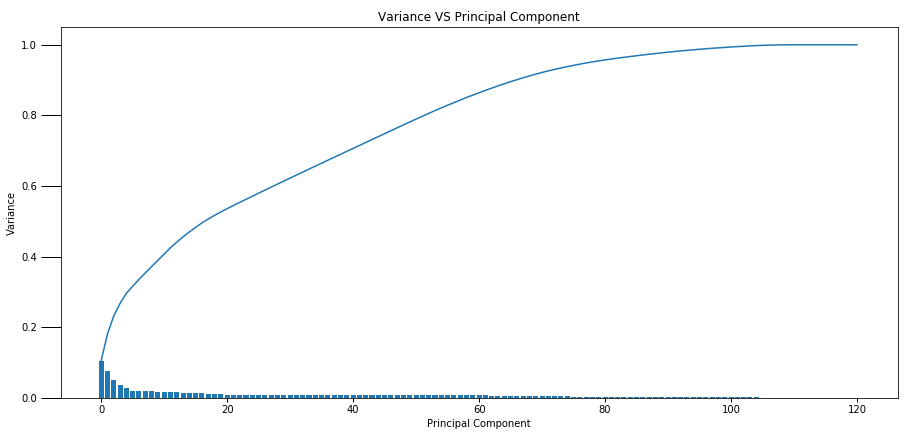

In [12]:
pca_var(pca)

In [13]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=80)

processed_df_fit_tranform_pca = pca.fit_transform(processed_df) 

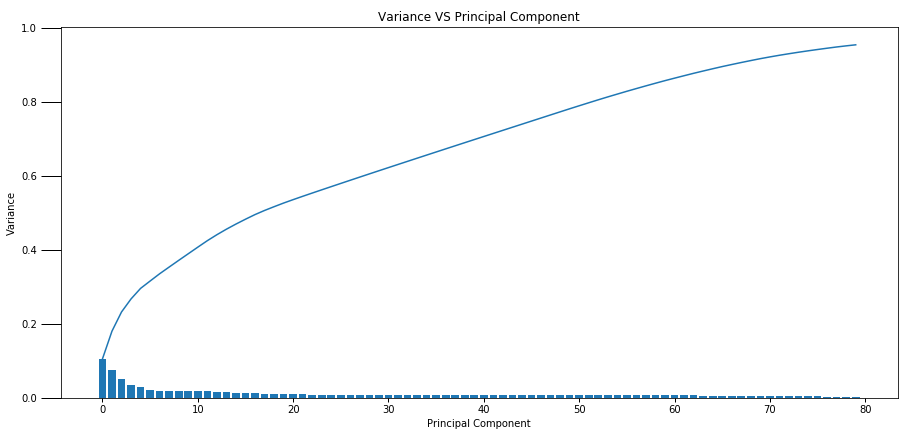

In [14]:
pca_var(pca)

### Discussion 2.2: Perform Dimensionality Reduction

How many principal components / transformed features are you retaining for the next step of the analysis?

I retiend 80 principal components since around 80 the variance is almost fully saturated at a value around .97

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [15]:
def pca_feature_weights(df,pca, principal_comp):
    mapped_weights = {}
    for num, feature in enumerate(df.columns):
        mapped_weights[feature] = pca.components_[principal_comp][num]
    
    return sorted(mapped_weights.items(), key=operator.itemgetter(1), reverse=True)
    

In [16]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

weights_1 = pca_feature_weights(processed_df,pca,1)
weights_1

[('ALTERSKATEGORIE_GROB', 0.2590027419413715),
 ('FINANZ_VORSORGER', 0.2340782352479517),
 ('SEMIO_ERL', 0.21698271528163382),
 ('SEMIO_LUST', 0.18059913488587997),
 ('RETOURTYP_BK_S', 0.1616897468677657),
 ('W_KEIT_KIND_HH', 0.12206264446717818),
 ('FINANZTYP', 0.11550525274230963),
 ('SEMIO_KRIT', 0.10040016683739779),
 ('FINANZ_HAUSBAUER', 0.09740406081694161),
 ('SHOPPER_TYP', 0.0963590160421225),
 ('SEMIO_KAEM', 0.08983380415398645),
 ('FINANZ_MINIMALIST', 0.08699230313323597),
 ('CAMEO_INTL_2015', 0.07510748034108823),
 ('EWDICHTE', 0.0744664024696185),
 ('CAMEO_INTL_TIER_2015', 0.07100322806108397),
 ('ANREDE_KZ', 0.06918955044112535),
 ('PLZ8_BAUMAX', 0.06749402555894819),
 ('ORTSGR_KLS9', 0.06588569551956688),
 ('PLZ8_ANTG3', 0.061461927531799354),
 ('PLZ8_ANTG2', 0.059895567492606244),
 ('ARBEIT', 0.05962168497871053),
 ('RELAT_AB', 0.05653255000794485),
 ('SEMIO_DOM', 0.054029779379497656),
 ('CAMEO_DEUG_2015_8', 0.05399337882588376),
 ('ANZ_HAUSHALTE_AKTIV', 0.0476362458939

In [17]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_2 = pca_feature_weights(processed_df,pca,2)
weights_2

[('SEMIO_VERT', 0.340002879680426),
 ('SEMIO_SOZ', 0.262321243851596),
 ('SEMIO_FAM', 0.2604224448359973),
 ('SEMIO_KULT', 0.2495741705302426),
 ('FINANZ_MINIMALIST', 0.1488636159636995),
 ('FINANZTYP', 0.11393684074218358),
 ('RETOURTYP_BK_S', 0.09496698690714549),
 ('SEMIO_REL', 0.09055516012513073),
 ('FINANZ_VORSORGER', 0.08003670955557021),
 ('W_KEIT_KIND_HH', 0.07950543102909043),
 ('SEMIO_MAT', 0.07207486273470166),
 ('ALTERSKATEGORIE_GROB', 0.055282573115409565),
 ('SEMIO_LUST', 0.04548135465177285),
 ('PLZ8_BAUMAX', 0.044102139171077845),
 ('PLZ8_ANTG3', 0.037838011931251095),
 ('CAMEO_DEUG_2015_8', 0.03662016755121035),
 ('CAMEO_INTL_2015', 0.03577099460587037),
 ('CAMEO_INTL_TIER_2015', 0.035673858166529245),
 ('EWDICHTE', 0.034908420671938535),
 ('LP_STATUS_GROB', 0.03484263025935114),
 ('ARBEIT', 0.033717293322437676),
 ('PLZ8_ANTG2', 0.030770339664689332),
 ('ORTSGR_KLS9', 0.028960170331597677),
 ('RELAT_AB', 0.028441587630556802),
 ('CAMEO_DEU_2015_9C', 0.024494005776956

In [18]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_3 = pca_feature_weights(processed_df,pca,3)
weights_3

[('LP_FAMILIE_GROB', 0.37695110734147186),
 ('LP_FAMILIE_FEIN', 0.36868239287910276),
 ('LP_LEBENSPHASE_FEIN', 0.353008604853661),
 ('ANZ_PERSONEN', 0.3263876810632377),
 ('LP_LEBENSPHASE_GROB', 0.3246004017580556),
 ('EWDICHTE', 0.17519289047433556),
 ('ORTSGR_KLS9', 0.16605999219479672),
 ('ONLINE_AFFINITAET', 0.15452279803174904),
 ('PLZ8_BAUMAX', 0.12179113622806775),
 ('RELAT_AB', 0.11671471175869451),
 ('ARBEIT', 0.11227197445614892),
 ('PLZ8_ANTG3', 0.11108082074635632),
 ('PLZ8_ANTG2', 0.09843115273716616),
 ('LP_STATUS_FEIN', 0.08223629410174592),
 ('CJT_GESAMTTYP', 0.06314276146102349),
 ('CAMEO_DEUG_2015_8', 0.06170689556236228),
 ('SEMIO_KAEM', 0.05567560233965088),
 ('SHOPPER_TYP', 0.055524940187302405),
 ('SEMIO_DOM', 0.055027511873797987),
 ('LP_STATUS_GROB', 0.05185271176900627),
 ('CAMEO_DEUG_2015_1', 0.04439650726173031),
 ('FINANZTYP', 0.0425974779753049),
 ('Altersjahr Abweichung', 0.03871657284745144),
 ('CAMEO_INTL_TIER_2015', 0.03626276648870547),
 ('CAMEO_INTL_2

### Discussion 2.3: Interpret Principal Components

####### Lets take a look at the first principal component here:
########### ALTERSKATEGORIE_GROB ('ALTERSKATEGORIE_GROB', 0.2590027416639959)
Which means customer segmentation has a strong relationshop with shopper type  ('SHOPPER_TYP', 0.09635901554390261) and is invesely proportional to ('Altersjahr Abweichung', -0.2429493432093856) age variance and age density ('Teenager-Mehrheitsjahr', -0.136898918983204). Which tells that customer segmentation is targeted to all ages.

####### Lets take a look at the second principal component here:
########### ('SEMIO_VERT', 0.3400028824629372)
Which means semi vertical has a strong relation with customer segmentation ('ALTERSKATEGORIE_GROB', 0.05528257585067174)
and ('CAMEO_INTL_TIER_2015', 0.035673860630903415) tiers levels of cameo. 
IT has a inverse relationship with age variance ('Altersjahr Abweichung', -0.08783546251489123) and age density ('Teenager-Mehrheitsjahr', -0.0821113795345573). Here verticals are more focused on age groups.

####### Lets take a look at the third principal component here:
########### ('LP_FAMILIE_GROB', 0.37695113904067906)
Which means LP family heavy or perhaps family focused. This principal is focused on age variance ('Altersjahr Abweichung', 0.03871658973838403) and cameo tiers ('CAMEO_INTL_TIER_2015', 0.0362627652621993). 
Although target audience varies in age but there is there alot of focus on it ('Teenager-Mehrheitsjahr', -0.04265406908597912).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [19]:
score_list = []

for cluster in range(1,30,10):
    # Over a number of different cluster counts...
    print("cluster: ", cluster)
    kmeans = KMeans(n_clusters= cluster)

    # run k-means clustering on the data and...
    model = kmeans.fit(processed_df_fit_tranform_pca)  
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(processed_df_fit_tranform_pca))    
    score_list.append(score)
    print("cluster ", cluster, " done!")


cluster:  1
cluster  1  done!
cluster:  11
cluster  11  done!
cluster:  21
cluster  21  done!


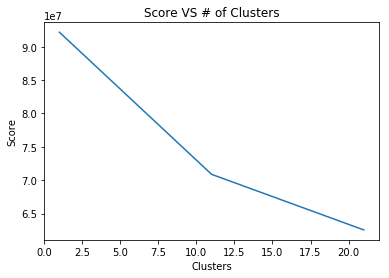

In [22]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
clusters = list(range(0,30,10))

plt.plot(clusters, score_list);
plt.xlabel('Clusters');
plt.ylabel('Score');
plt.title('Score VS # of Clusters');

In [31]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters= 20)
azd_fit = kmeans.fit(processed_df_fit_tranform_pca)
azd_predict = azd_fit.predict(processed_df_fit_tranform_pca)

In [36]:
len(azd_predict)

798049

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)\

I have decided to set it to 20 clusters since there is fairly high score and processing speed on cpu is still relative decent.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [58]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [59]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_processed = clean_data(customers)



Removing int val: -1 from the feature AGER_TYP
Removing string val: -1 from the feature AGER_TYP
Removing int val: -1 from the feature ALTERSKATEGORIE_GROB
Removing string val: -1 from the feature ALTERSKATEGORIE_GROB
Removing int val: -1 from the feature ANREDE_KZ
Removing string val: -1 from the feature ANREDE_KZ
Removing int val: -1 from the feature CJT_GESAMTTYP
Removing string val: -1 from the feature CJT_GESAMTTYP
Removing int val: -1 from the feature FINANZ_MINIMALIST
Removing string val: -1 from the feature FINANZ_MINIMALIST
Removing int val: -1 from the feature FINANZ_SPARER
Removing string val: -1 from the feature FINANZ_SPARER
Removing int val: -1 from the feature FINANZ_VORSORGER
Removing string val: -1 from the feature FINANZ_VORSORGER
Removing int val: -1 from the feature FINANZ_ANLEGER
Removing string val: -1 from the feature FINANZ_ANLEGER
Removing int val: -1 from the feature FINANZ_UNAUFFAELLIGER
Removing string val: -1 from the feature FINANZ_UNAUFFAELLIGER
Removing 

Removing string val: -1 from the feature PLZ8_ANTG3
Removing int val: -1 from the feature PLZ8_ANTG4
Removing string val: -1 from the feature PLZ8_ANTG4
Removing int val: -1 from the feature PLZ8_BAUMAX
Removing string val: -1 from the feature PLZ8_BAUMAX
Removing int val: -1 from the feature PLZ8_HHZ
Removing string val: -1 from the feature PLZ8_HHZ
Removing int val: -1 from the feature PLZ8_GBZ
Removing string val: -1 from the feature PLZ8_GBZ
Removing int val: -1 from the feature ARBEIT
Removing string val: -1 from the feature ARBEIT
Removing int val: -1 from the feature ORTSGR_KLS9
Removing string val: -1 from the feature ORTSGR_KLS9
Removing int val: -1 from the feature RELAT_AB
Removing string val: -1 from the feature RELAT_AB
Removing alphabets: X from the feature AGER_TYP
Removing alphabets: X from the feature ALTERSKATEGORIE_GROB
Removing alphabets: X from the feature ANREDE_KZ
Removing alphabets: X from the feature CJT_GESAMTTYP
Removing alphabets: X from the feature FINANZ_M

Removing string val: 0 from the feature SEMIO_VERT
Removing int val: 0 from the feature SEMIO_LUST
Removing string val: 0 from the feature SEMIO_LUST
Removing int val: 0 from the feature SEMIO_ERL
Removing string val: 0 from the feature SEMIO_ERL
Removing int val: 0 from the feature SEMIO_KULT
Removing string val: 0 from the feature SEMIO_KULT
Removing int val: 0 from the feature SEMIO_RAT
Removing string val: 0 from the feature SEMIO_RAT
Removing int val: 0 from the feature SEMIO_KRIT
Removing string val: 0 from the feature SEMIO_KRIT
Removing int val: 0 from the feature SEMIO_DOM
Removing string val: 0 from the feature SEMIO_DOM
Removing int val: 0 from the feature SEMIO_KAEM
Removing string val: 0 from the feature SEMIO_KAEM
Removing int val: 0 from the feature SEMIO_PFLICHT
Removing string val: 0 from the feature SEMIO_PFLICHT
Removing int val: 0 from the feature SEMIO_TRADV
Removing string val: 0 from the feature SEMIO_TRADV
Removing int val: 0 from the feature SHOPPER_TYP
Removin

Removing alphabets: XX from the feature HH_EINKOMMEN_SCORE
Removing alphabets: XX from the feature KK_KUNDENTYP
Removing alphabets: XX from the feature W_KEIT_KIND_HH
Removing alphabets: XX from the feature WOHNDAUER_2008
Removing alphabets: XX from the feature ANZ_HAUSHALTE_AKTIV
Removing alphabets: XX from the feature ANZ_HH_TITEL
Removing alphabets: XX from the feature GEBAEUDETYP
Removing alphabets: XX from the feature KONSUMNAEHE
Removing alphabets: XX from the feature MIN_GEBAEUDEJAHR
Removing alphabets: XX from the feature OST_WEST_KZ
Removing alphabets: XX from the feature WOHNLAGE
Removing alphabets: XX from the feature CAMEO_DEUG_2015
Removing alphabets: XX from the feature CAMEO_DEU_2015
Removing alphabets: XX from the feature CAMEO_INTL_2015
Removing alphabets: XX from the feature KBA05_ANTG1
Removing alphabets: XX from the feature KBA05_ANTG2
Removing alphabets: XX from the feature KBA05_ANTG3
Removing alphabets: XX from the feature KBA05_ANTG4
Removing alphabets: XX from 

Removing int val: 9 from the feature CAMEO_INTL_2015
Removing string val: 9 from the feature CAMEO_INTL_2015
Removing int val: 9 from the feature KBA05_ANTG1
Removing string val: 9 from the feature KBA05_ANTG1
Removing int val: 9 from the feature KBA05_ANTG2
Removing string val: 9 from the feature KBA05_ANTG2
Removing int val: 9 from the feature KBA05_ANTG3
Removing string val: 9 from the feature KBA05_ANTG3
Removing int val: 9 from the feature KBA05_ANTG4
Removing string val: 9 from the feature KBA05_ANTG4
Removing int val: 9 from the feature KBA05_BAUMAX
Removing string val: 9 from the feature KBA05_BAUMAX
Removing int val: 9 from the feature KBA05_GBZ
Removing string val: 9 from the feature KBA05_GBZ
Removing int val: 9 from the feature BALLRAUM
Removing string val: 9 from the feature BALLRAUM
Removing int val: 9 from the feature EWDICHTE
Removing string val: 9 from the feature EWDICHTE
Removing int val: 9 from the feature INNENSTADT
Removing string val: 9 from the feature INNENSTAD

C:\Users\Wrangler\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Wrangler\Anaconda3\lib\site-packages\ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['VERS_TYP', 'OST_WEST_KZ', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] 


117 total features after one-hot encoding. 


['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GFK_URLAUBERTYP', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP', 'ANZ_PERSONEN', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE

In [62]:
normalizer = StandardScaler()

customers_processed[customers_processed.columns] = normalizer.fit_transform(customers_processed[customers_processed.columns].values)

pca = PCA(n_components=80)

customers_processed_pca = pca.fit_transform(customers_processed) 

kmeans = KMeans(n_clusters= 20)
customers_fit = kmeans.fit(customers_processed_pca)
customers_predict = customers_fit.predict(customers_processed_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

<function matplotlib.pyplot.show(*args, **kw)>

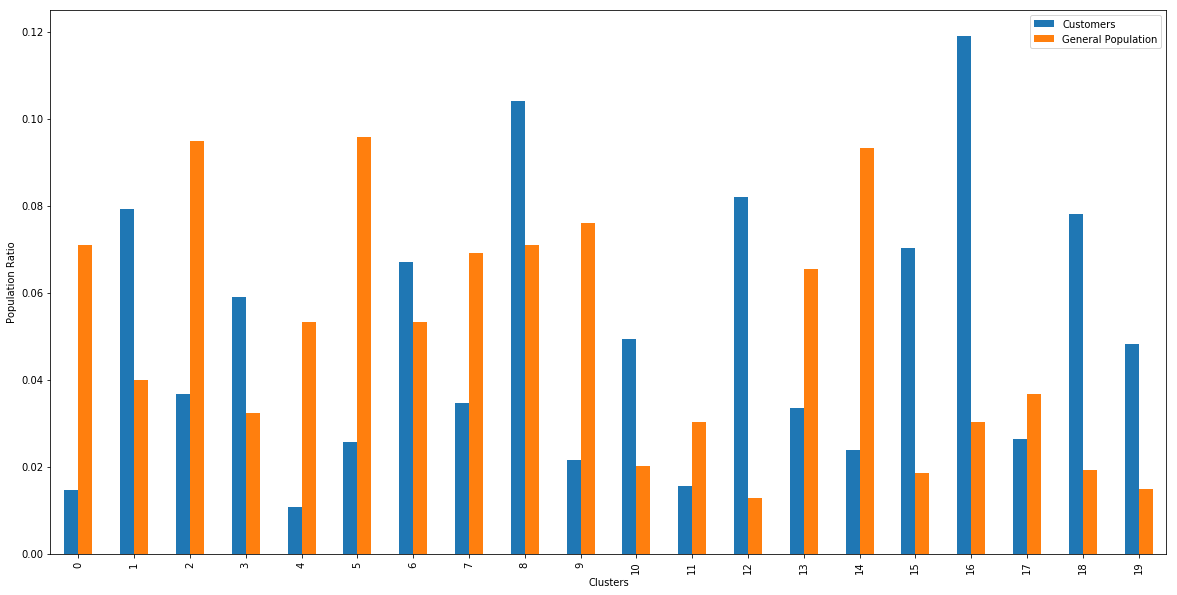

In [63]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cust_list = []
gen_pop_list = []


for n in range(20):
    cust_list.append((customers_predict == n).sum()/len(customers_predict))
    gen_pop_list.append((azd_predict == n).sum()/len(azd_predict))
                           
df_data = pd.DataFrame({"Clusters" : list(range(20)) , "Customers" : cust_list , "General Population":gen_pop_list })

df_data.plot(x= 'Clusters', y = ["Customers", "General Population"], kind = "bar", figsize = (20,10))
plt.ylabel('Population Ratio')
plt.show

In [71]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cust_over = normalizer.inverse_transform(pca.inverse_transform(customers_processed_pca[np.where(customers_predict==5)]))
cust_over_df = pd.DataFrame(data = cust_over, columns = customers_processed.columns, 
                            index = np.array(range(cust_over.shape[0])))

cust_over_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Altersjahr Abweichung,Teenager-Mehrheitsjahr,CAMEO_INTL_TIER_2015
0,-1.238437,-0.740254,-0.034517,1.024201,-0.450141,0.366439,-0.169001,0.304111,-0.936452,-1.338782,...,-0.155856,-0.110155,-0.085251,-0.096765,-0.077651,-0.083758,-0.123790,0.285160,-0.004238,-1.130229
1,-0.816039,-0.777131,0.729434,0.424547,-0.307109,0.487172,0.251802,-1.150293,-0.255971,1.073291,...,-0.130066,-0.107789,-0.093713,-0.081502,-0.086027,-0.122171,-0.031066,-0.287501,1.456684,-1.110570
2,-0.268456,-0.685979,0.650822,0.761987,-0.302430,0.317352,-0.487763,0.070430,-0.435328,-1.325062,...,-0.146036,-0.134191,-0.093600,-0.085087,-0.080852,-0.108651,-0.099003,-0.180015,0.063344,-1.126825
3,0.676515,-0.559611,-0.633690,0.922662,-0.745903,0.727652,-0.606006,-0.403002,-0.559726,-1.085092,...,-0.086441,-0.140762,-0.050834,-0.072183,-0.101806,-0.154464,-0.177589,-0.567048,-1.232005,-1.172908
4,0.504219,-0.859727,-1.279375,0.940328,-0.601452,0.506756,-0.637727,-0.134234,-0.675314,-1.083220,...,-0.138016,-0.162752,-0.059388,-0.075149,-0.070861,-0.130443,-0.237388,-0.462675,0.043056,-1.174651


In [69]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cust_over = normalizer.inverse_transform(pca.inverse_transform(customers_processed_pca[np.where(customers_predict==16)]))
cust_over_df = pd.DataFrame(data = cust_over, columns = customers_processed.columns, 
                            index = np.array(range(cust_over.shape[0])))

cust_over_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,Altersjahr Abweichung,Teenager-Mehrheitsjahr,CAMEO_INTL_TIER_2015
0,0.374576,-0.706367,-0.672528,0.683375,-0.671733,0.632507,-0.407431,-0.631689,-0.242935,-1.223663,...,-0.145359,-0.137266,-0.077481,-0.083819,-0.079689,-0.106972,-0.139258,-0.535172,1.430279,-0.425172
1,-0.024747,-1.036102,-0.694082,0.993533,-0.786242,0.415556,-0.936758,0.092028,-0.321135,-1.384072,...,-0.142661,-0.133468,-0.096628,-0.103530,-0.116443,-0.165149,-0.171117,-0.506639,-1.186477,-0.490397
2,0.547007,1.381098,-0.698041,-0.212497,-0.600475,0.711623,-0.221826,0.121209,0.509259,-1.281169,...,-0.147582,-0.124658,-0.083050,-0.075045,-0.069268,-0.091169,-0.096456,-0.424335,1.414370,-0.386480
3,0.428111,-0.686003,-0.671429,0.214924,-0.247580,0.267187,-0.496986,-1.045583,0.166072,0.487861,...,-0.142708,-0.099730,-0.086263,-0.086451,-0.081271,-0.080382,-0.063923,-0.319487,-0.022547,-0.379307
4,-0.719509,-0.376331,-0.026874,0.774753,-0.606981,0.446799,-0.449610,0.252656,-0.408069,-1.266914,...,-0.143995,-0.121297,-0.094733,-0.090009,-0.081519,-0.105098,-0.073930,-0.175681,-0.006044,-0.417625


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Teengers and young childern above 9 are relatively popular with the company. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.